In [228]:
import os
import json
import csv
import pandas as pd
import random, string, re, collections
import numpy as np
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib 
import seaborn as sns

import torch
# from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA

# from adjustText import adjust_text
import colorsys

from plot_utilities import *

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.decomposition import IncrementalPCA

In [229]:
from importlib import reload
import plot_utilities
reload(plot_utilities)

<module 'plot_utilities' from '/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py'>

In [5]:
def ensure_directory(file_name):
    """Ensure that the directory for the given file name exists. Create it if it does not."""
    dir_name = os.path.dirname(file_name)
    if not os.path.exists(dir_name) and dir_name:
        os.makedirs(dir_name)


In [6]:
# compute the rank of each role per dataset 
def get_dataset_acc_mean_rank(df, attribute='merged_cate'):
    mean_df = df.groupby([attribute, 'dataset'])['accuracy'].mean().reset_index()
    mean_df['rank'] = mean_df.groupby('dataset')['accuracy'].rank(ascending=False)
    
    mean_rank_df = mean_df.groupby(attribute)['rank'].mean()
    var_rank = mean_df.groupby(attribute)['rank'].var()
    
    rank_df = pd.DataFrame({
        'mean_rank': mean_rank_df,
        'variance_of_rank': var_rank}).reset_index()
    return mean_df, rank_df

def get_role_acc_mean_rank(df):
#     mean_df = df.groupby(['role', 'merged_cate','dataset', 'full_question', 'question_id'])['accuracy'].mean().reset_index()
#     mean_df['rank'] = mean_df.groupby('role')['accuracy'].rank(ascending=False)
    mean_df = df.groupby(['role', 'merged_cate'])['accuracy'].mean().reset_index()
    
    # Rank the roles based on mean accuracy
    mean_df['rank'] = mean_df['accuracy'].rank(ascending=False)
    
    return mean_df

In [7]:
def drop_duplicate_ans(identifier_col, ans_df):
    return ans_df[identifier_col].drop_duplicates()

In [8]:
def create_full_question(row):
    question_text = row['question']
    option1 = row["option1"]
    option2 = row["option2"]
    option3 = row["option3"]
    option4 = row["option4"]

    choices_text = f'Options: 1. {option1}, 2. {option2}, 3. {option3}, 4. {option4}.'
    return f"{question_text} {choices_text}"


# Load data

## Load question and role data

In [9]:
# ques_df = pd.read_csv("../data/final_mmlu_sample_ques.csv")
# ques_df['full_question'] = ques_df.apply(create_full_question, axis=1)
# ques_df = ques_df[~ques_df['full_question'].duplicated(keep="first")]
# ques_df.to_csv("../data/mmlu_sample_ques_unique.csv", index=False)

ques_df = pd.read_csv("../data/mmlu_sample_ques_unique.csv")
role_df_path = "../data/final-final-role-cate.csv"
role_df = pd.read_csv(role_df_path)

## re-do classification
# classification_question_split = pd.read_csv("../data/question_split.csv")
classification_question_split = pd.read_csv("../data/question_split_final.csv")
test_ques_df = classification_question_split[classification_question_split['split'] == 'test']
train_ques_df = classification_question_split[classification_question_split['split'] == 'train']

In [10]:
test_ques_df.shape

(462, 13)

In [11]:
ques_df.columns

Index(['question', 'subject', 'true_option', 'groundtruth', 'dataset',
       'length', 'question_id', 'option1', 'option2', 'option3', 'option4',
       'full_question'],
      dtype='object')

In [12]:
ques_df.shape

(2410, 12)

In [13]:
classification_question_split.shape

(2410, 13)

In [14]:
ques_df['full_length'] = ques_df['full_question'].apply(lambda x: len(x.split()))
# ques_df['full_length'].describe()
ques_df['full_length'].quantile(0.99)

146.90999999999985

## Load answer results

In [15]:
'''
Load role-prompt answers
'''

model_path_dic = {'flan': "../data/mmlu_role_ans/flan_xxl_result_full.csv",
                  'llama3-8B': "../data/model_updated/llama_results/llama3_result_acc.csv", 
                  'mistral': '../data/model_updated/mistral_results/mistral_result_acc.csv',
                  'qwen2.5-7B': "../data/Qwen/Qwen2.5-7B_result_acc.csv",
                  'qwen2.5-72B': "../data/Qwen/Qwen2.5-72B_result_acc.csv",
                  'llama3-70B': "../data/llama70_results_CR/llama3_70_results_acc_all_prompts.csv",
                }

model_ans_dic = {}
columns_to_keep = ['model', 'role', 'merged_cate', 'mmlu', 'prompt', 'question_id', 'dataset', 'accuracy', 'full_question']
inter_prompts = ['Imagine you are talking to your {role}.', 'You are talking to your {role}.']

for m, ans_path in model_path_dic.items():
    df = pd.read_csv(ans_path)
    ans_df = df.merge(ques_df[['question_id', 'dataset', 'full_question']], 
                      on=['question_id', 'dataset'], how='right') 
    ans_df = pd.merge(ans_df, role_df[['role', 'merged_cate', 'mmlu']], how='left')
    
    if m == 'flan':
        ans_df['prompt'] = ans_df['prompt'].str.replace('{relationship}. {question_text}', '{role}.')
    # exclude interpersonal prompts
    ans_df = ans_df[~ans_df['prompt'].isin(inter_prompts)]
    # add model name to each data frame 
    ans_df['model'] = m 
    ans_df = ans_df[columns_to_keep]
    model_ans_dic[m] = ans_df.drop_duplicates(subset=['role', 'prompt', 'full_question'])

In [16]:
ques_df.columns

Index(['question', 'subject', 'true_option', 'groundtruth', 'dataset',
       'length', 'question_id', 'option1', 'option2', 'option3', 'option4',
       'full_question', 'full_length'],
      dtype='object')

### Load Qwen2.5 results - 7 model sizes 

In [17]:
qwen_ans_dic = {}
qwen_ctrl_dic = {}
qwen_sizes = [0.5, 1.5, 3, 7, 14, 32, 72]
qwen_ctrl_mean = pd.DataFrame()
for model_size in qwen_sizes:
    df = pd.read_csv(f'../data/Qwen/Qwen2.5-{model_size}B_result_acc.csv')
    ans_df = df.merge(ques_df[['question_id', 'dataset', 'full_question']], 
                      on=['question_id', 'dataset'], how='right') 
    # print(ans_df.columns)
    ans_df = pd.merge(ans_df, role_df[['role', 'merged_cate', 'mmlu']], how='left')
    ans_df = ans_df[~ans_df['prompt'].isin(inter_prompts)]
    model_name = f"qwen2.5-{model_size}B"
    ans_df['model'] = model_name
    ans_df = ans_df[columns_to_keep]
    qwen_ans_dic[model_name] = ans_df.drop_duplicates(subset=['role', 'prompt', 'full_question'])
    
    ctrl_df = pd.read_csv(f'../data/Qwen/Qwen2.5-{model_size}B_control_acc.csv')
    ctrl_df = pd.merge(ctrl_df, ques_df[['question_id', 'dataset', 'full_question']],
                       on=['question_id', 'dataset'], how='right')
    qwen_ctrl_dic[model_name] = ctrl_df 
    control_value = ctrl_df['accuracy'].mean()
    temp_df = pd.DataFrame({'model': [model_name], 'control': [control_value]})
    qwen_ctrl_mean = pd.concat([qwen_ctrl_mean, temp_df])

for m, df in qwen_ctrl_dic.items():
    df['merged_cate'] = 'no role'
    df['role'] = 'no role'
    df['model'] = m 
    df['prompt'] = 'no role'
    qwen_ctrl_dic[m] = df
    

In [253]:
qwen_ans_dic.keys()

dict_keys(['qwen2.5-0.5B', 'qwen2.5-1.5B', 'qwen2.5-3B', 'qwen2.5-7B', 'qwen2.5-14B', 'qwen2.5-32B', 'qwen2.5-72B'])

### No role prompt

In [20]:
model_control_mean = pd.DataFrame()
model_ctrl_dic = {}
norole_path_dic = {'mistral': "../data/model_updated/no_role/mistral_control_acc.csv",
                   'qwen2.5-7B': "../data/Qwen/Qwen2.5-7B_control_acc.csv", 
                   'qwen2.5-72B': "../data/Qwen/Qwen2.5-72B_control_acc.csv", 
                   'llama3-8B': "../data/model_updated/no_role/llama_control_acc.csv",
                   'llama3-70B': "../data/llama70_results/no_role/llama3_70_control_acc.csv",
                   'flan': "../data/control/no_role/flan_results/flan_xxl_control_acc.csv"
                  }

for model_name, ans_path in norole_path_dic.items():
    model_data = pd.read_csv(ans_path)
    model_data = pd.merge(model_data, ques_df[['question_id', 'dataset', 'full_question']],
                          on=['question_id', 'dataset'], how='right')
    model_ctrl_dic[model_name] = model_data
    control_value = model_data['accuracy'].mean()
    temp_df = pd.DataFrame({'model': [model_name], 'control': [control_value]})
    model_control_mean = pd.concat([model_control_mean, temp_df])

for m, df in model_ctrl_dic.items():
    df['merged_cate'] = 'no role'
    df['role'] = 'no role'
    df['model'] = m 
    df['prompt'] = 'no role'
    model_ctrl_dic[m] = df

In [21]:
model_control_mean

model   control
0      mistral  0.426556
0   qwen2.5-7B  0.718257
0  qwen2.5-72B  0.802905
0    llama3-8B  0.534855
0   llama3-70B  0.744398
0         flan  0.498340

In [22]:
overall_control_mean = model_control_mean['control'].mean()
overall_control_mean

0.6208852005532504

In [23]:
qwen_ctrl_mean

model   control
0  qwen2.5-0.5B  0.344813
0  qwen2.5-1.5B  0.495436
0    qwen2.5-3B  0.614108
0    qwen2.5-7B  0.718257
0   qwen2.5-14B  0.760581
0   qwen2.5-32B  0.804149
0   qwen2.5-72B  0.802905

# Process data

In [24]:
def process_model_results(model_ans_dic):
    results = {}
    for model_name, df in model_ans_dic.items():
        role_dataset_mean, role_dataset_rank = get_dataset_acc_mean_rank(df, 'role')
        rolecate_dataset_mean, rolecate_dataset_ranks = get_dataset_acc_mean_rank(df)
        
        role_mean_rank = get_role_acc_mean_rank(df)
        
        prompt_ques_mean = df.groupby(['prompt', 'dataset', 'full_question'])['accuracy'].mean().reset_index()
        
        agg_rolecate_acc = df.groupby('merged_cate')['accuracy'].mean().sort_values(ascending=False).reset_index()
        
        role_ques_mean = df.groupby(['role', 'question_id', 'merged_cate'])['accuracy'].mean().reset_index()
        # Storing results
        results[model_name] = {
            'role': {'dataset_mean': role_dataset_mean, 
                     'dataset_rank': role_dataset_rank, 
                     'agg_mean': role_mean_rank,
                     'ques_mean': role_ques_mean},
            'rolecate': {'dataset_mean': rolecate_dataset_mean, 
                         'dataset_rank': rolecate_dataset_ranks, 
                         'agg_mean':agg_rolecate_acc},
            'prompt_ques_mean': prompt_ques_mean,
        }
    return results

In [25]:
qwen_results_all = process_model_results(qwen_ans_dic)

In [26]:
model_results_all = process_model_results(model_ans_dic)


# Role vs. No Role

In [181]:
def combine_data(dic, label):
    combined_df = pd.concat([df[['accuracy','role','model','prompt']].assign(Type=label).reset_index(drop=True) for _, df in dic.items()])
    return combined_df

# model_ctrl_dic - NO ROLE
combined_ctrl = combine_data(model_ctrl_dic, "No Role")
combined_ans = combine_data(model_ans_dic, "Role")
combined_data = pd.concat([combined_ctrl, combined_ans]).reset_index(drop=True)

In [256]:
qwen_combined_ctrl = combine_data(qwen_ctrl_dic, "No Role")
qwen_combined_ans = combine_data(qwen_ans_dic, "Role")
qwen_combined_data = pd.concat([qwen_combined_ctrl, qwen_combined_ans]).reset_index(drop=True)

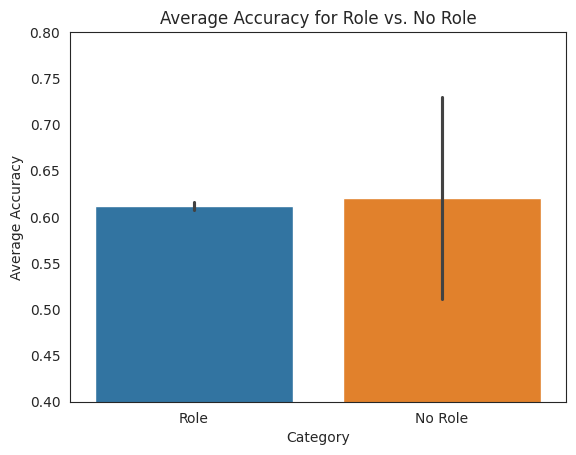

In [252]:
# Plot role vs. no-role accuracy
## aggregate over 6 models
tdf = combined_data
tdf = tdf.groupby(['role', 'model', 'prompt', 'Type'])['accuracy'].mean().reset_index()
sns.barplot(data=tdf, x='Type', y='accuracy', hue='Type')
plt.title('Average Accuracy for Role vs. No Role')
plt.ylim(0.4, 0.8)
plt.ylabel('Average Accuracy')
plt.xlabel('Category')
plt.show()

# Regression plotting functions

In [239]:
def results_summary_to_dataframe(results):
    '''take the result of an statsmodel results table and transforms it into a dataframe'''
    pvals = results.pvalues
    coeff = results.params
    se = results.bse
    conf_lower = results.conf_int()[0]
    conf_higher = results.conf_int()[1]

    results_df = pd.DataFrame({"p value":pvals,
                               "coeff":coeff,
                               "SE":se,
                               "conf_lower":conf_lower,
                               "conf_higher":conf_higher
                                })

    #Reordering...
    results_df = results_df.reset_index()
    results_df['term'] = results_df['index']
#     results_df = results_df[~results_df['index'].isin(['Group Var'])]
    results_df = results_df[~results_df['index'].isin(['Intercept', 'Group Var'])]
#     print(results_df['term'])
           
    results_df['term'] = [re.sub('T.', '', it[:-1].split('T.')[1]) if len(it.split('.')) > 1 else it[3:-2] for it in results_df['term']]
    return results_df

In [240]:
def plot_reg_results(df, nrows=1, ncols=1, figsize=(4, 4), labelsize=14, xlabel='xlabel', title='', filename=None, ref=None, xytext=(0.55, 0.95), ref_line=True, colors=None):
    df = df.sort_values('coeff')
    xs = df['coeff']
    norm = mcolors.Normalize(vmin=min(xs)*2, vmax=max(xs)*2)
    mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
    default_colors = np.array([(mapper.to_rgba(v)) for v in xs])
    if colors is None:
        colors = default_colors
    en_len = int(len(df))
     
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    axes=[axes] if nrows + ncols <= 2 else axes
    
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.6)
    if len(title) > 0:
        plt.title(title)
    st = fig.suptitle("", fontsize=14)

    for i in range(len(axes)):
        ax = axes[i]
        ax.set_ylim(-0.7, len(df['term'][:en_len])-0.2)
        # reference line 
        if ref_line:
            ax.axvline(x=0.00,color='black',linewidth=1.3,linestyle='--')

            if ref:
                # annotate the reference group
                ax.annotate(f'{ref}', xy=(0, len(df['term']) - 0.7), 
                            xytext=xytext, textcoords='axes fraction',
                            arrowprops=dict(facecolor='black', shrink=0.05, lw=0.5, width=1.5, headwidth=5),
                            fontsize=13, ha='left', va='top')

        ax.xaxis.grid(False)
        ax.yaxis.label.set_color('white')
        ax.set_xlabel(xlabel, fontsize=labelsize)
        ax.tick_params(axis='x', labelsize=labelsize)

        s = en_len*i
        en = en_len*(i+1) 
        for x, y, e, p, color in zip(df['coeff'][s:en], df['term'][s:en], df['SE'][s:en],df['p value'][s:en], colors[s:en]):
            ax.errorbar(x=[x], y=[y], xerr=[e], color=color,fmt='o')
            sig = ' '
            if p < 0.05:
                sig = '*'
            if p < 0.01:
                sig = '**'
            if p < 0.001:
                sig = '***'
            ax.annotate(sig, # this is the text
                     (x+0.00001,y), # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,-0.5), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center

        ax.set_yticklabels(list(df['term']), fontsize=labelsize)

    #fig.text(0.5, 0.04, 'common X', ha='center')
    st.set_y(-0.02)
            
    if filename:
        ensure_directory(filename)
        plt.savefig(filename, bbox_inches='tight')
        

In [241]:
def plot_reg_results_combined(ax, df, xlabel='xlabel', title='', filename=None, ref=None, xytext=(0.55, 0.95), ref_line=True, colors=None):
    df = df.sort_values('coeff')
    xs = df['coeff']
    norm = mcolors.Normalize(vmin=min(xs)*2, vmax=max(xs)*2)
    mapper = cm.ScalarMappable(norm=norm, cmap='viridis')
    default_colors = np.array([(mapper.to_rgba(v)) for v in xs])
    if colors is None:
        colors = default_colors
    en_len = int(len(df))
     
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
#     axes=[axes] if nrows + ncols <= 2 else axes
    
#     plt.tight_layout()
#     plt.subplots_adjust(wspace=0.6)
#     st = fig.suptitle("", fontsize=14)

#     for i in range(len(axes)):
#         ax = axes[i]
    ax.set_ylim(-0.7, len(df['term'][:en_len])-0.2)
    # reference line 
    if ref_line:
        ax.axvline(x=0.00,color='black',linewidth=1.3,linestyle='--')

        if ref:
            # annotate the reference group
            ax.annotate(f'Reference: {ref}', xy=(0, len(df['term']) - 0.5), 
                        xytext=xytext, textcoords='axes fraction',
                        arrowprops=dict(facecolor='black', shrink=0.05, lw=0.5, width=1.5, headwidth=5),
                        fontsize=13, ha='left', va='top')

    ax.xaxis.grid(False)
    ax.yaxis.label.set_color('white')
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='x', labelsize=14)

#     s = en_len*i
#     en = en_len*(i+1) 
    for x, y, e, p, color in zip(df['coeff'], df['term'], df['SE'],df['p value'], colors):
        ax.errorbar(x=[x], y=[y], xerr=[e], color=color,fmt='o')
        sig = ' '
        if p < 0.05:
            sig = '*'
        if p < 0.01:
            sig = '**'
        if p < 0.001:
            sig = '***'
        ax.annotate(sig, # this is the text
                 (x+0.00001,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,-0.5), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

    ax.set_yticklabels(list(df['term']), fontsize=14)

    #fig.text(0.5, 0.04, 'common X', ha='center')
#     st.set_y(-0.02)
        
    if len(title) > 0:
        ax.set_title(title, fontsize=16)
        
    if filename:
        ensure_directory(filename)
        plt.savefig(filename, bbox_inches='tight')
        

# I. Overall Results

In [255]:
combined_data['model'].unique()

array(['mistral', 'qwen2.5-7B', 'qwen2.5-72B', 'llama3-8B', 'llama3-70B',
       'flan'], dtype=object)

## accuracy ~ role + 1|model (Appendix)

/opt/anaconda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_4108145/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


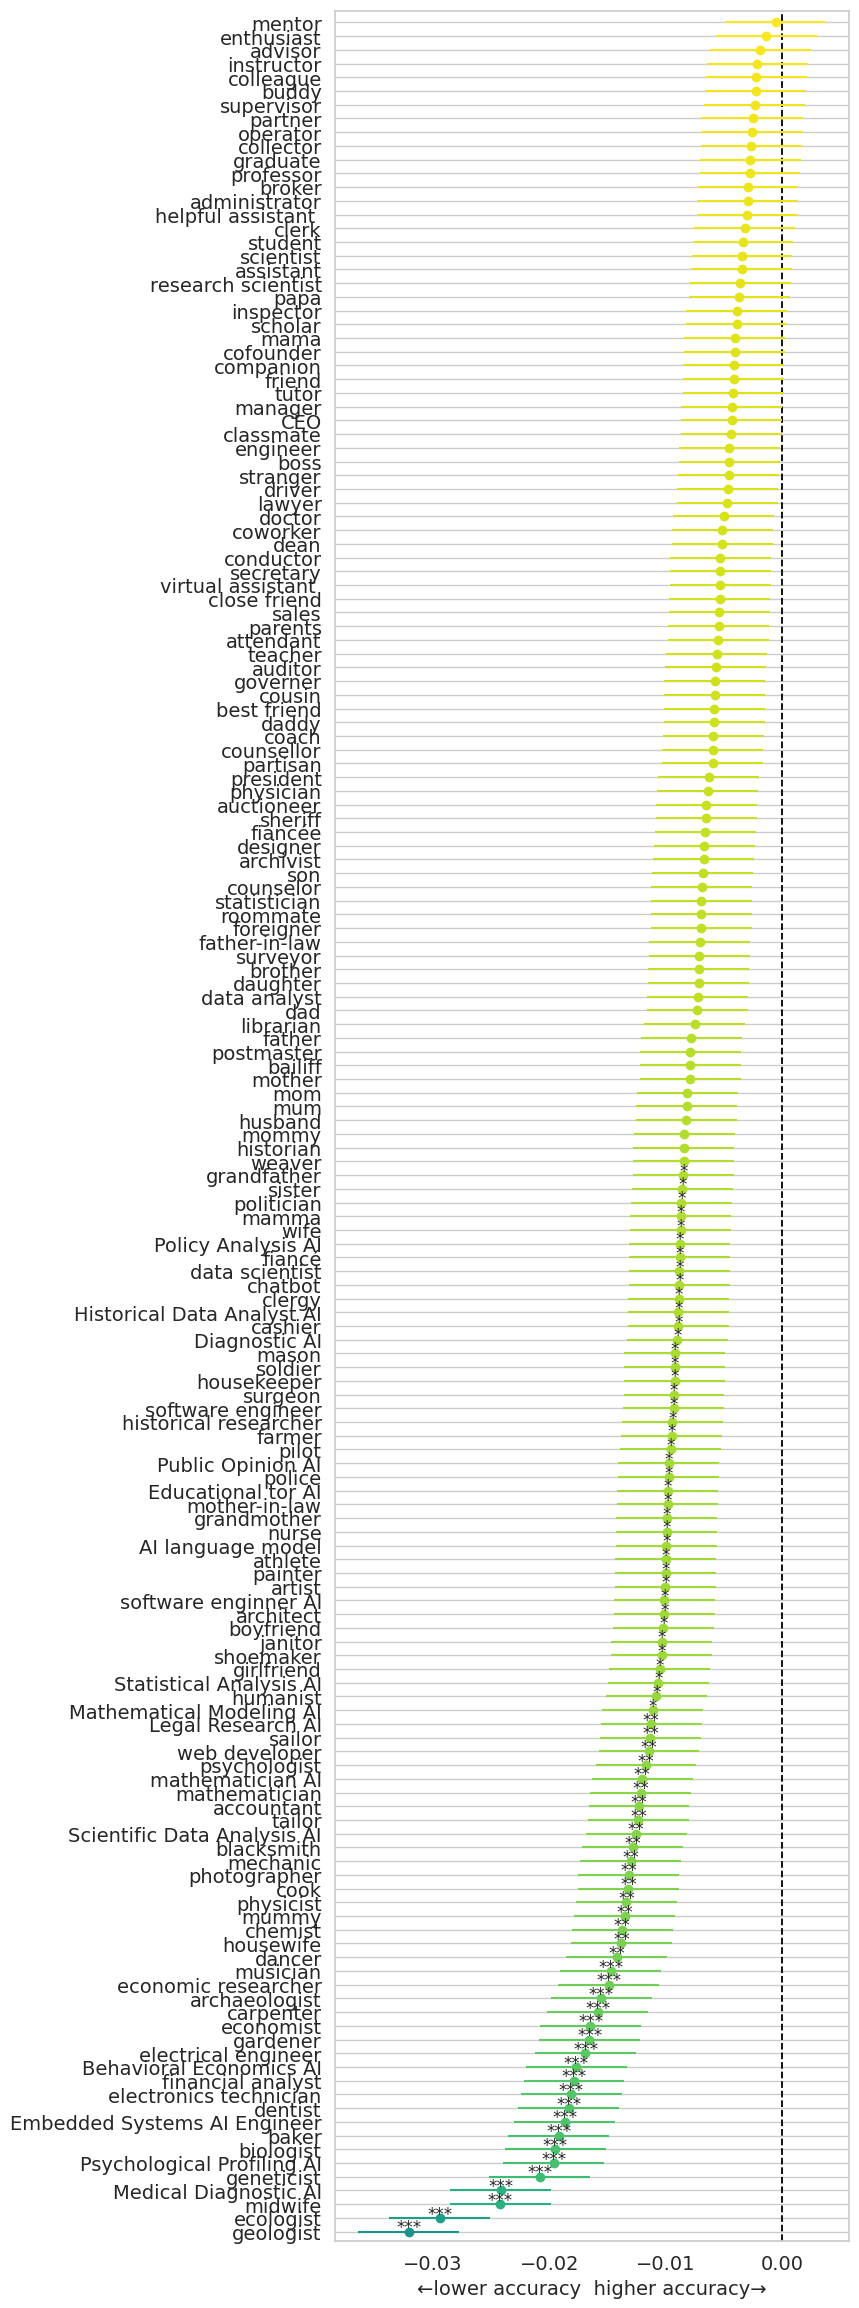

In [374]:
# over all experiment data (replace Fig2)
# accuracy ~ role + 1|model

tdf = combined_data
model = smf.mixedlm("accuracy ~ C(role, Treatment(reference='no role'))", data=tdf, groups=tdf['model'], re_formula="1")
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)
plot_reg_results(model_sum_df, figsize=(6,23),
                 xlabel="←lower accuracy  higher accuracy→",
                 filename = '../shared_data/figures/emnlp-CR/acc_role_mlm.pdf')

/tmp/ipykernel_4108145/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


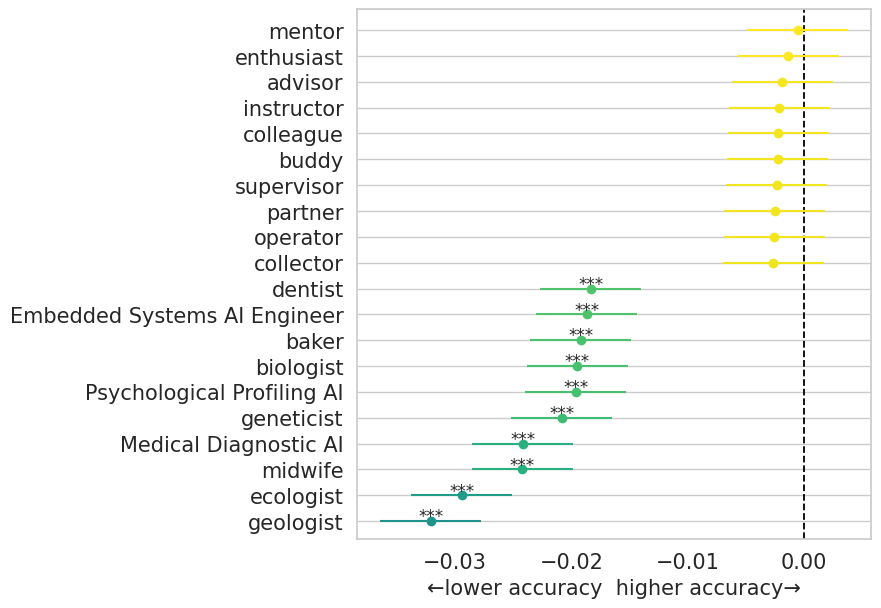

In [375]:
# regression of results from 6 models 
model_sum_df = model_sum_df.sort_values(by='coeff')

first_10 = model_sum_df.head(10)
last_10 = model_sum_df.tail(10)

combined_df = pd.concat([first_10, last_10])

plot_reg_results(combined_df, figsize=(6,6), 
                 labelsize=15,
                #  ref="no role", xytext=(0.65,0.97),
                 xlabel="←lower accuracy  higher accuracy→", 
                #  title="accuracy~role+(1|model)",
                 filename = '../shared_data/figures/emnlp-CR/acc_role_mlm_top10.pdf')

/tmp/ipykernel_4108145/385214043.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=14)
/tmp/ipykernel_4108145/385214043.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=14)
/tmp/ipykernel_4108145/385214043.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=14)
/tmp/ipykernel_4108145/385214043.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=14)
/tmp/ipykernel_4108145/385214043.py:54: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, 

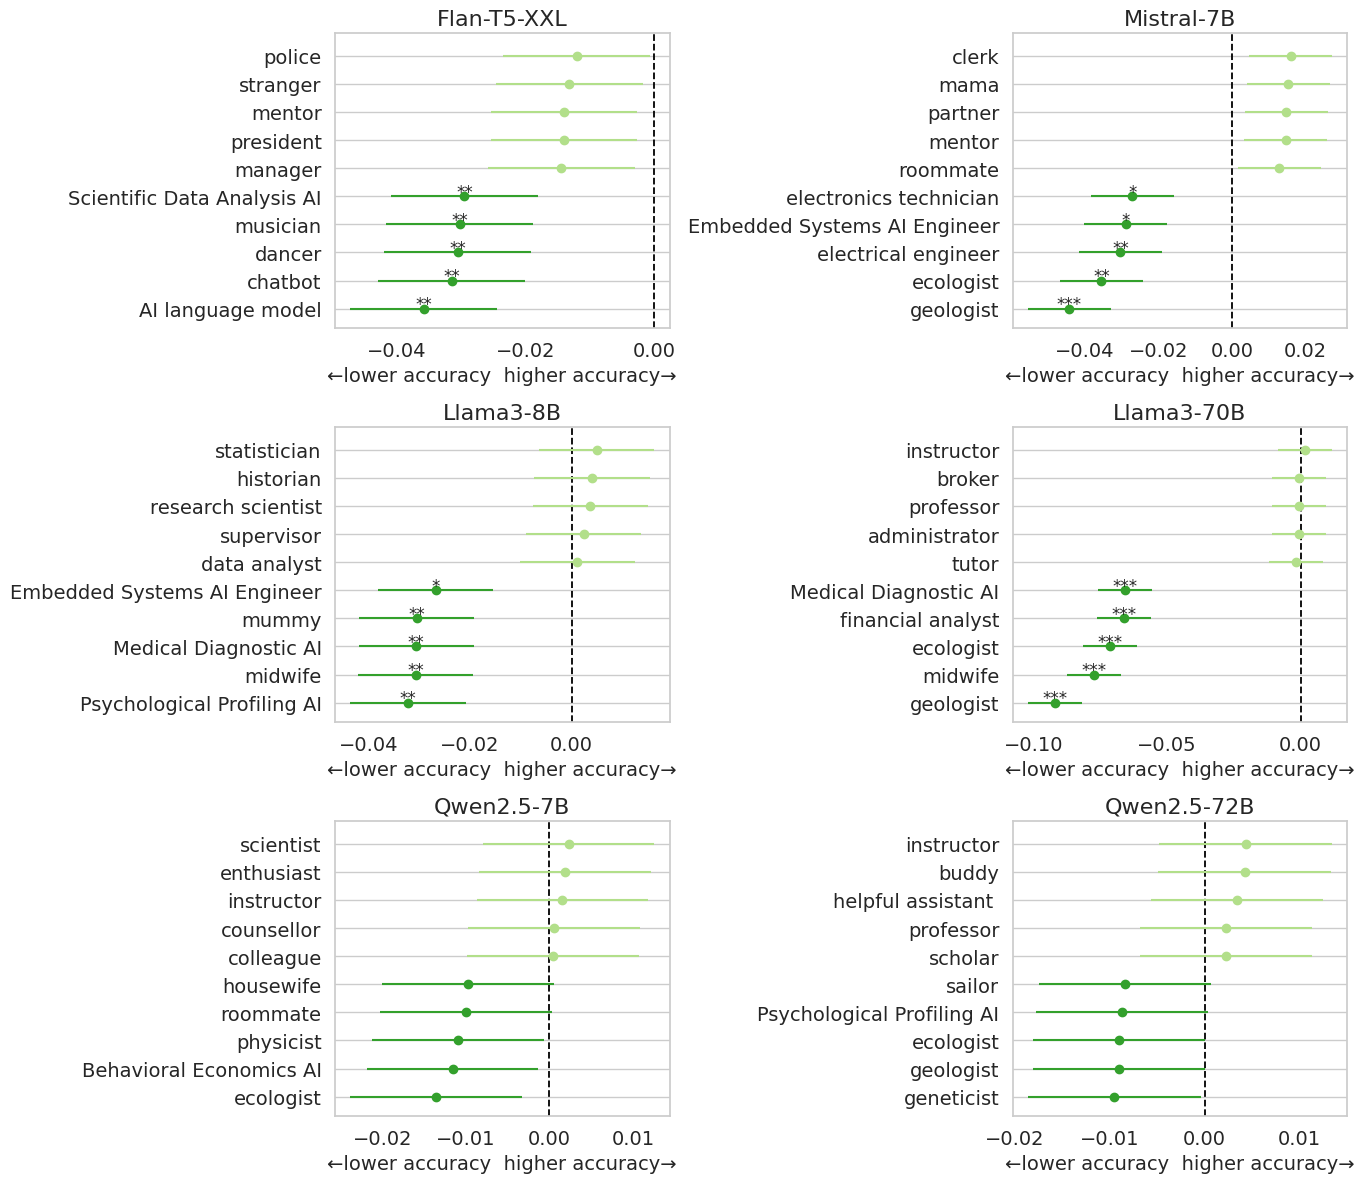

In [295]:
fig, axs = plt.subplots(3, 2, figsize=(14, 12))

models = ['flan', 'mistral', 'llama3-8B', 'llama3-70B', 'qwen2.5-7B', 'qwen2.5-72B']
titles = ['Flan-T5-XXL', 'Mistral-7B', 'Llama3-8B', 'Llama3-70B', 'Qwen2.5-7B', 'Qwen2.5-72B']

for i, (model_name, title) in enumerate(zip(models, titles)):
    tdf = combined_data[combined_data['model'] == model_name]

    model = smf.ols(f"accuracy ~ C(role, Treatment(reference='no role'))", data=tdf)
    result = model.fit()
    model_sum_df = results_summary_to_dataframe(result)
    model_sum_df = model_sum_df.sort_values(by='coeff')
    model_sum_df['term'] = model_sum_df['term'].replace({'parents': 'parent',
                                                         'Educational tor AI': 'Educational Tutor AI'})

    first = model_sum_df.head(5)
    last = model_sum_df.tail(5)

    combined_df = pd.concat([first, last])

    palette = sns.color_palette("Paired")
    light_color = palette[2]
    dark_color = palette[3]

    row, col = divmod(i, 2)
    plot_reg_results_combined(axs[row, col], combined_df, 
                     xlabel="←lower accuracy  higher accuracy→",
                     title=title,
                     colors=[dark_color]*5 + [light_color]*5)

plt.tight_layout()
plt.savefig('../shared_data/figures/emnlp-CR/acc_role_reg_combined.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_3414007/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


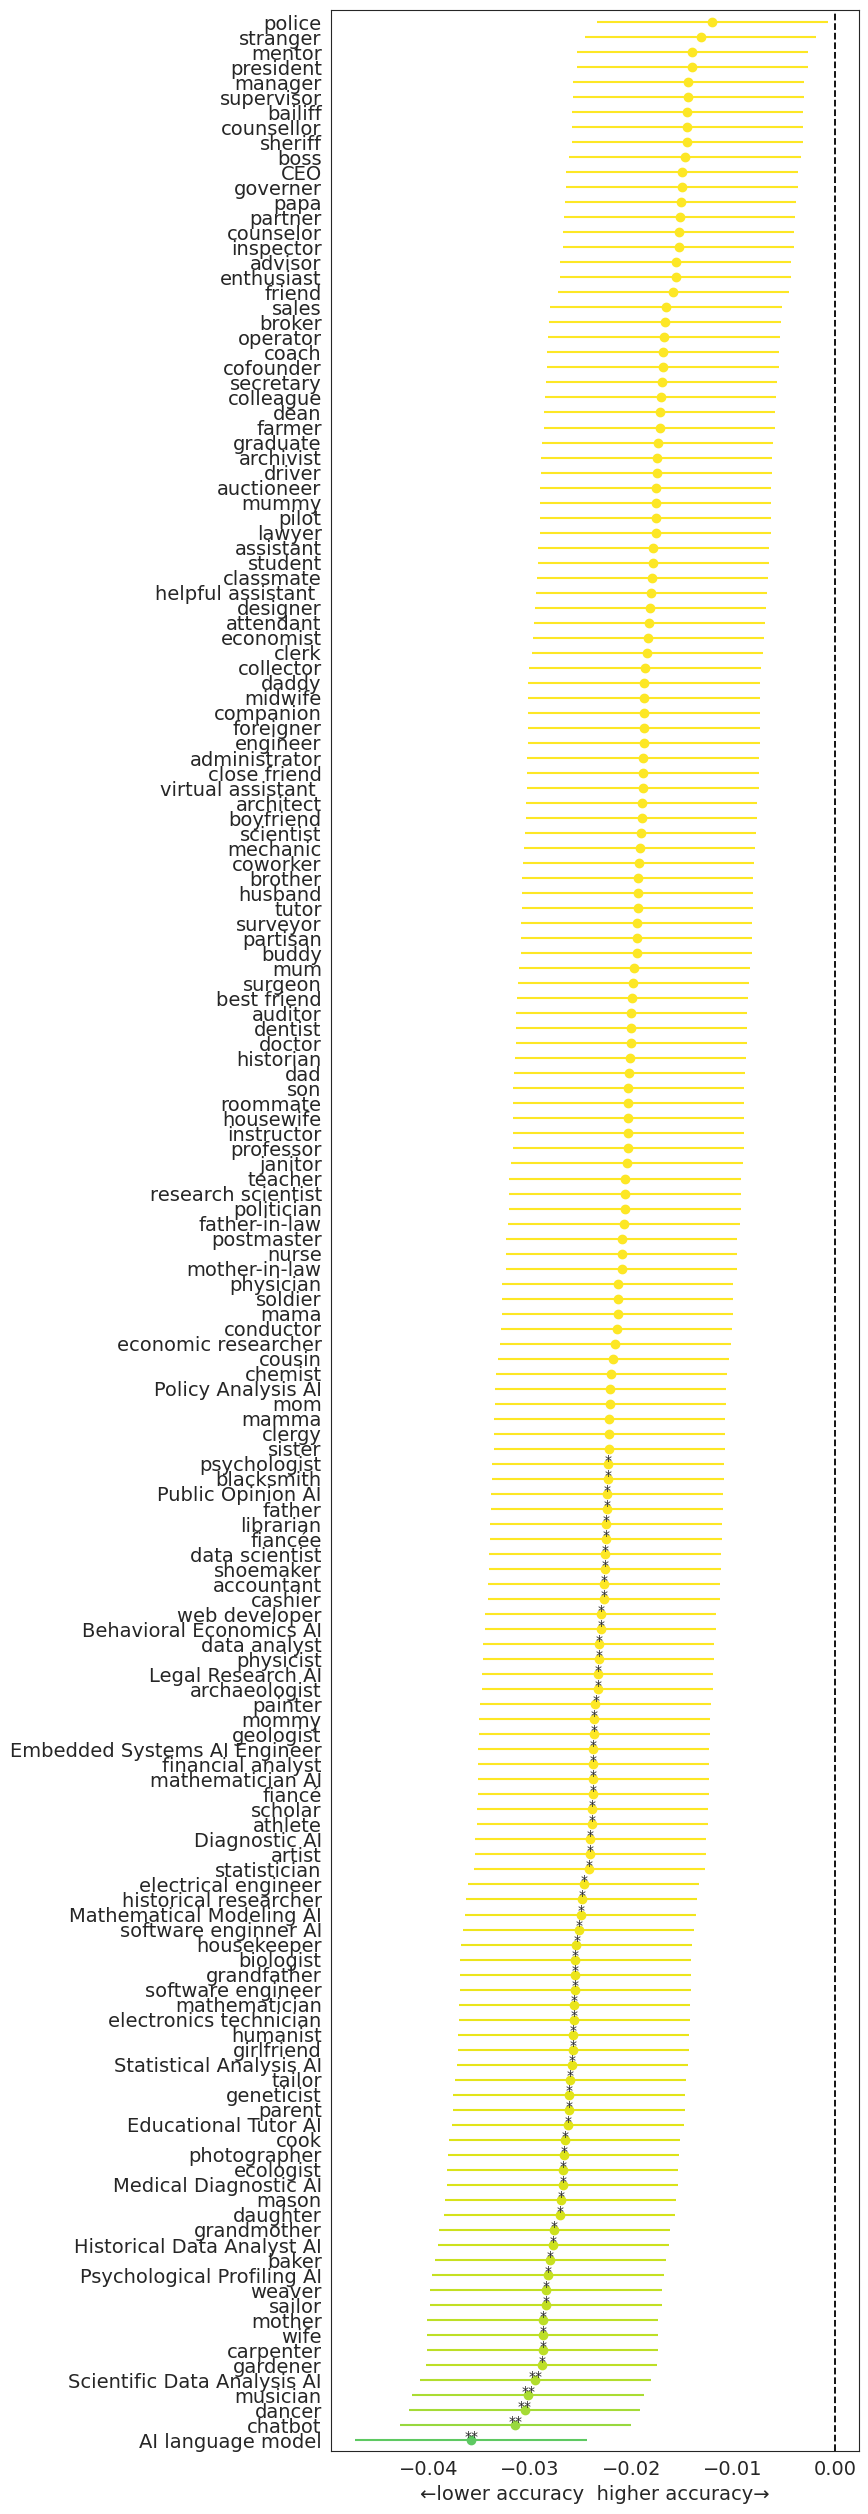

In [260]:
# accuracy ~ role (flan)

tdf = combined_data[combined_data['model'] == 'flan']

model = smf.ols("accuracy ~ C(role, Treatment(reference='no role'))", data=tdf)
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)
model_sum_df = model_sum_df.sort_values(by='coeff')

model_sum_df['term'] = model_sum_df['term'].replace({'parents': 'parent',
                                                    'Educational tor AI': 'Educational Tutor AI'})

plot_reg_results(model_sum_df, figsize=(6, 25),
                 xlabel="←lower accuracy  higher accuracy→",
                 filename = '../shared_data/figures/emnlp-CR/acc_role_reg_flan_appx.pdf')


/tmp/ipykernel_3414007/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


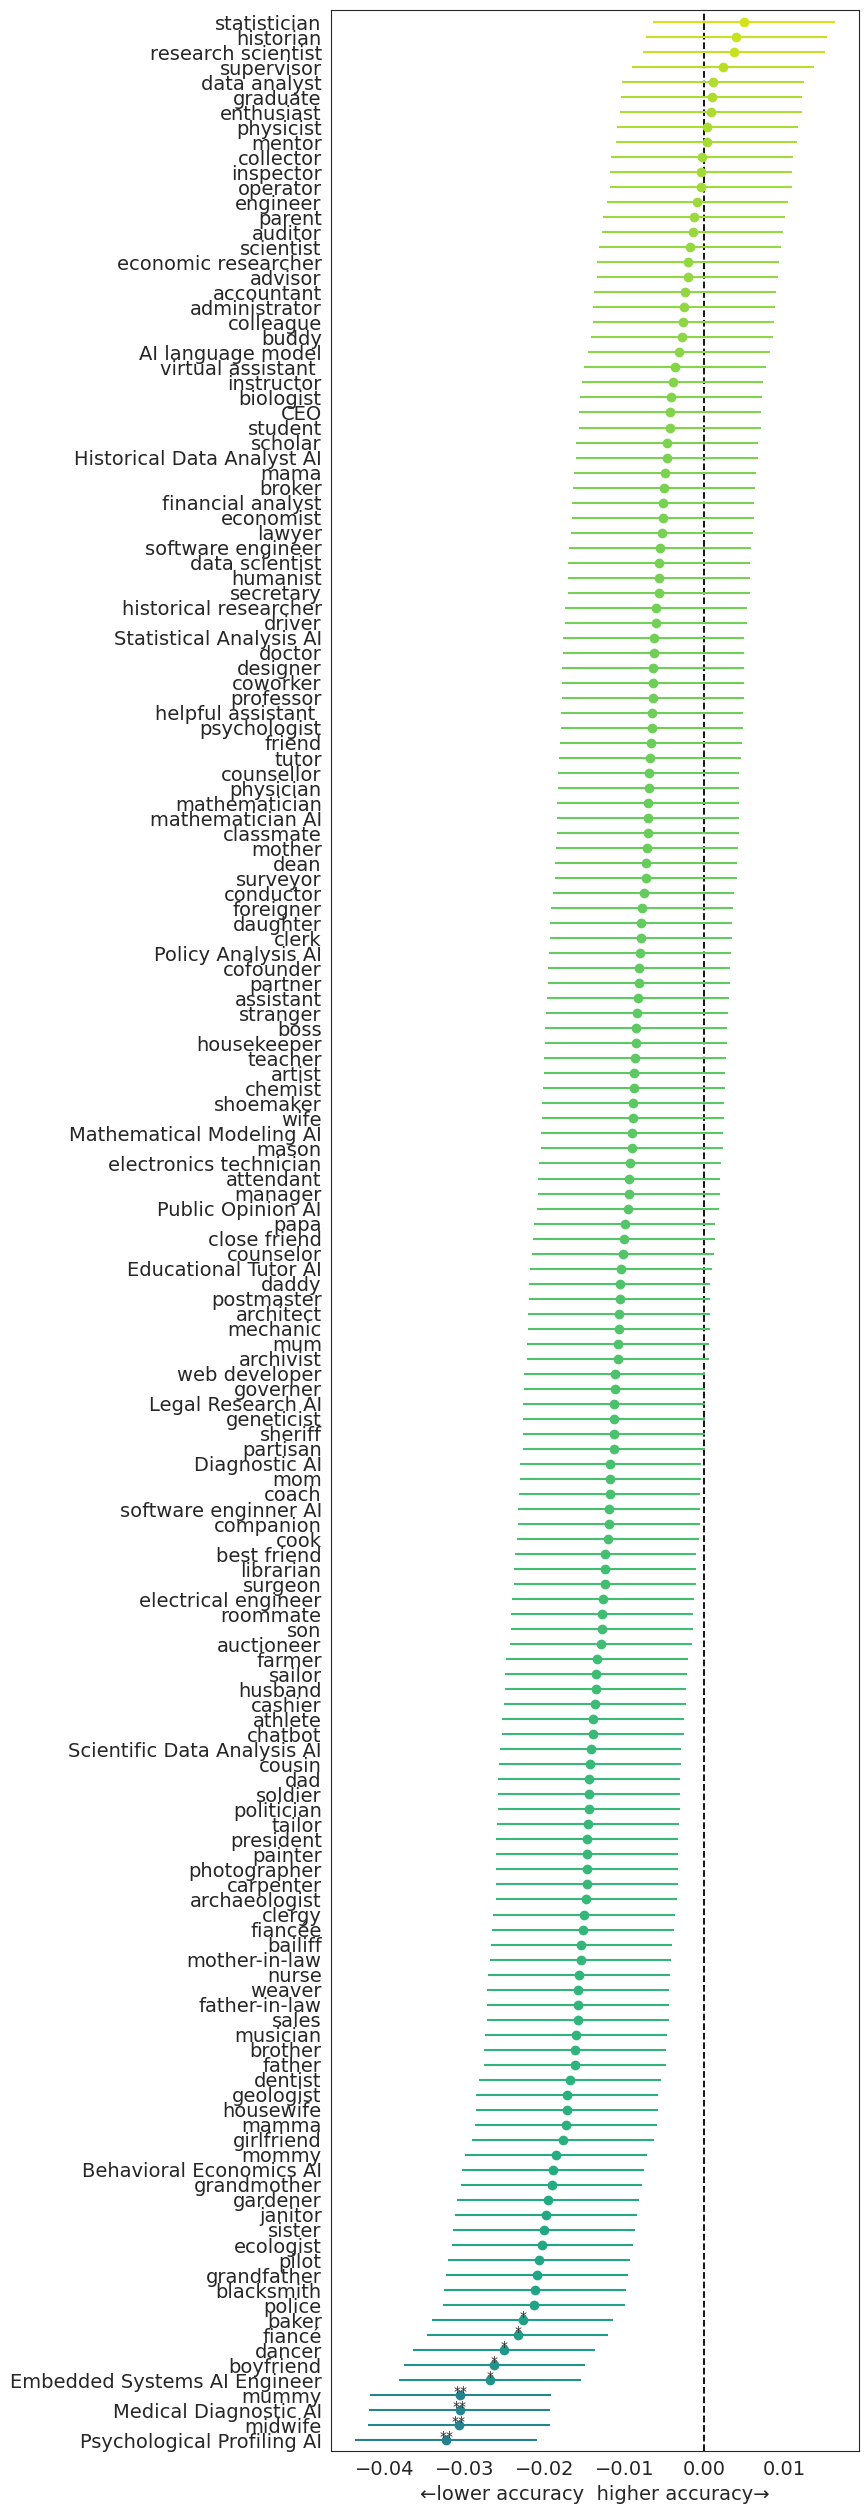

In [267]:
# accuracy ~ role (llama)

tdf = combined_data[combined_data['model'] == 'llama3-8B']

model = smf.ols("accuracy ~ C(role, Treatment(reference='no role'))", data=tdf)
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)
model_sum_df = model_sum_df.sort_values(by='coeff')

model_sum_df['term'] = model_sum_df['term'].replace({'parents': 'parent',
                                                    'Educational tor AI': 'Educational Tutor AI'})

plot_reg_results(model_sum_df, figsize=(6, 25),
                 xlabel="←lower accuracy  higher accuracy→",
                 filename = '../shared_data/figures/emnlp-CR/acc_role_reg_llama_appx.pdf')


/tmp/ipykernel_3414007/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


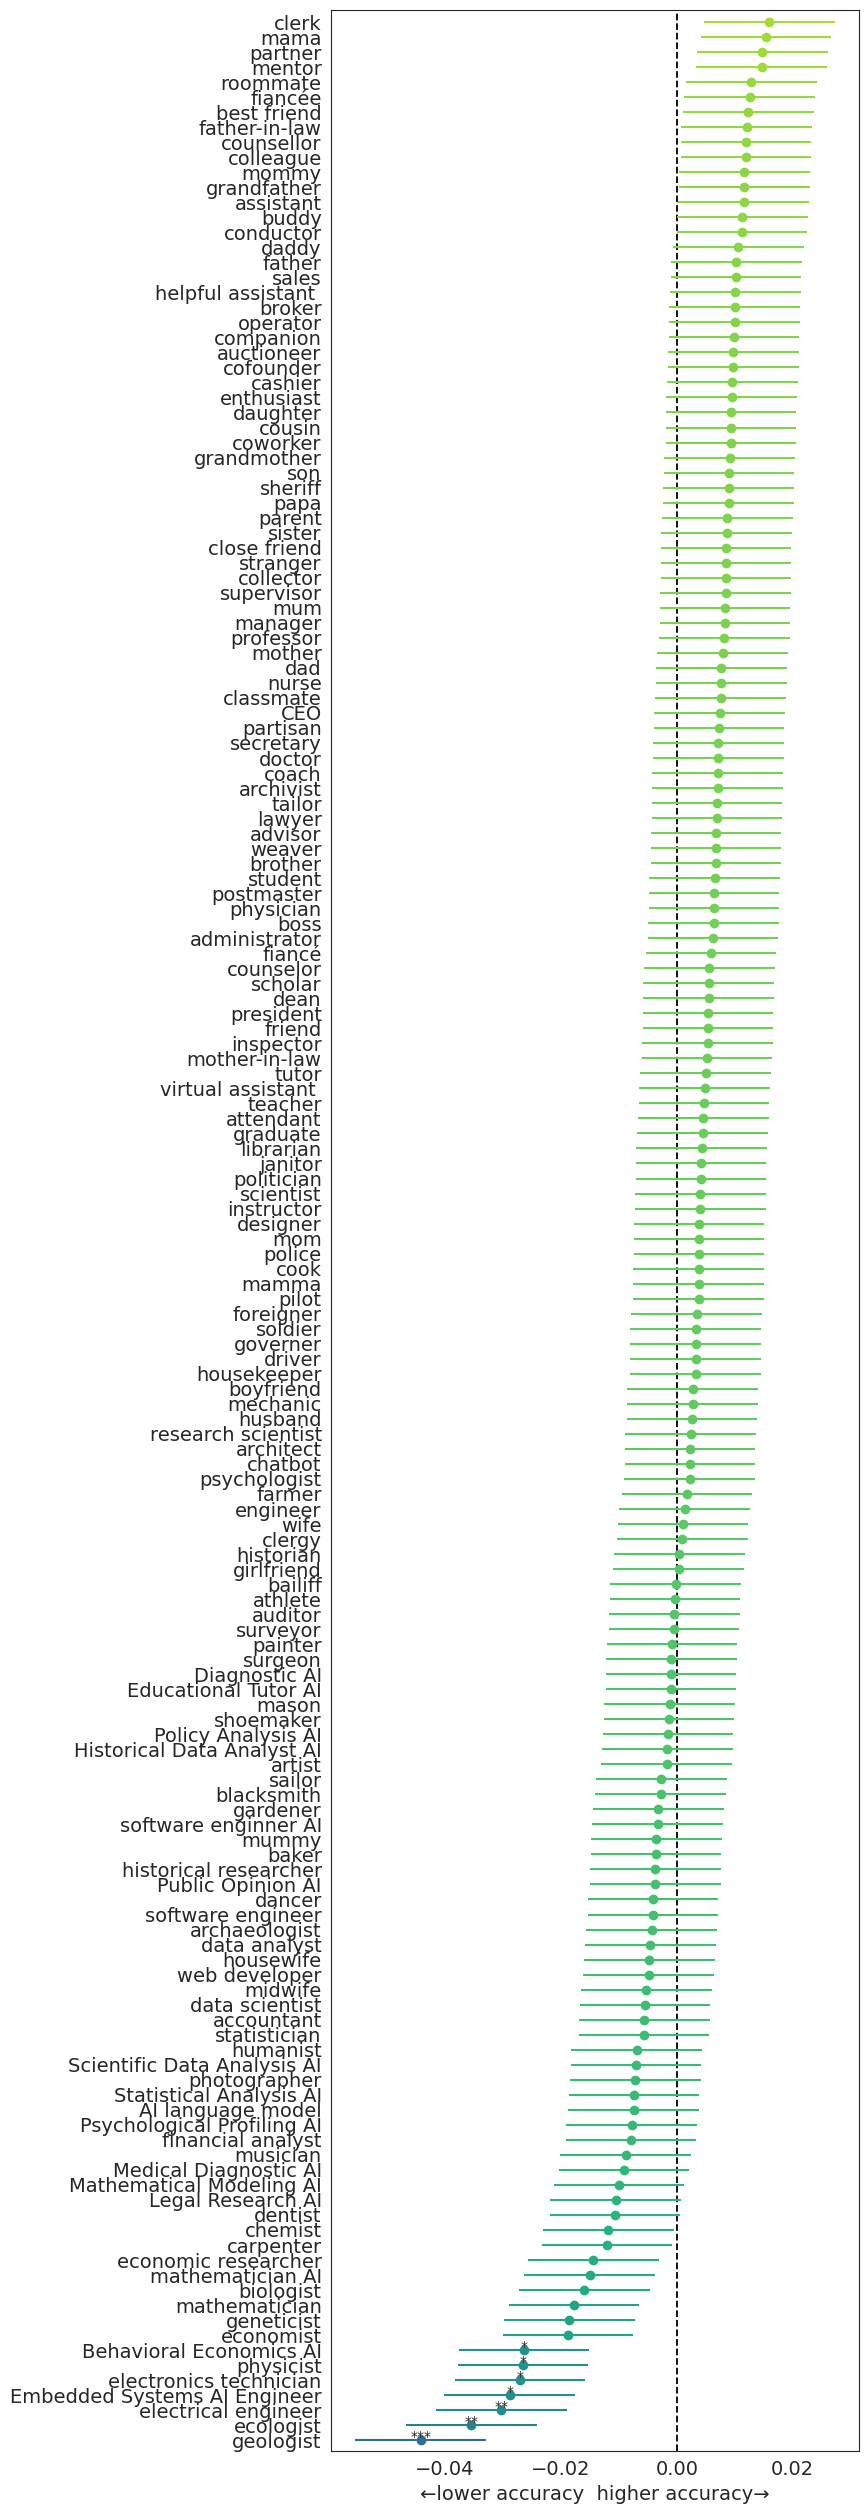

In [268]:
# accuracy ~ role (mistral)

tdf = combined_data[combined_data['model'] == 'mistral']

model = smf.ols("accuracy ~ C(role, Treatment(reference='no role'))", data=tdf)
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)
model_sum_df = model_sum_df.sort_values(by='coeff')

model_sum_df['term'] = model_sum_df['term'].replace({'parents': 'parent',
                                                    'Educational tor AI': 'Educational Tutor AI'})

plot_reg_results(model_sum_df, figsize=(6, 25),
                 xlabel="←lower accuracy  higher accuracy→",
                 filename = '../shared_data/figures/emnlp-CR/acc_role_reg_mistral_appx.pdf')


/tmp/ipykernel_3414007/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


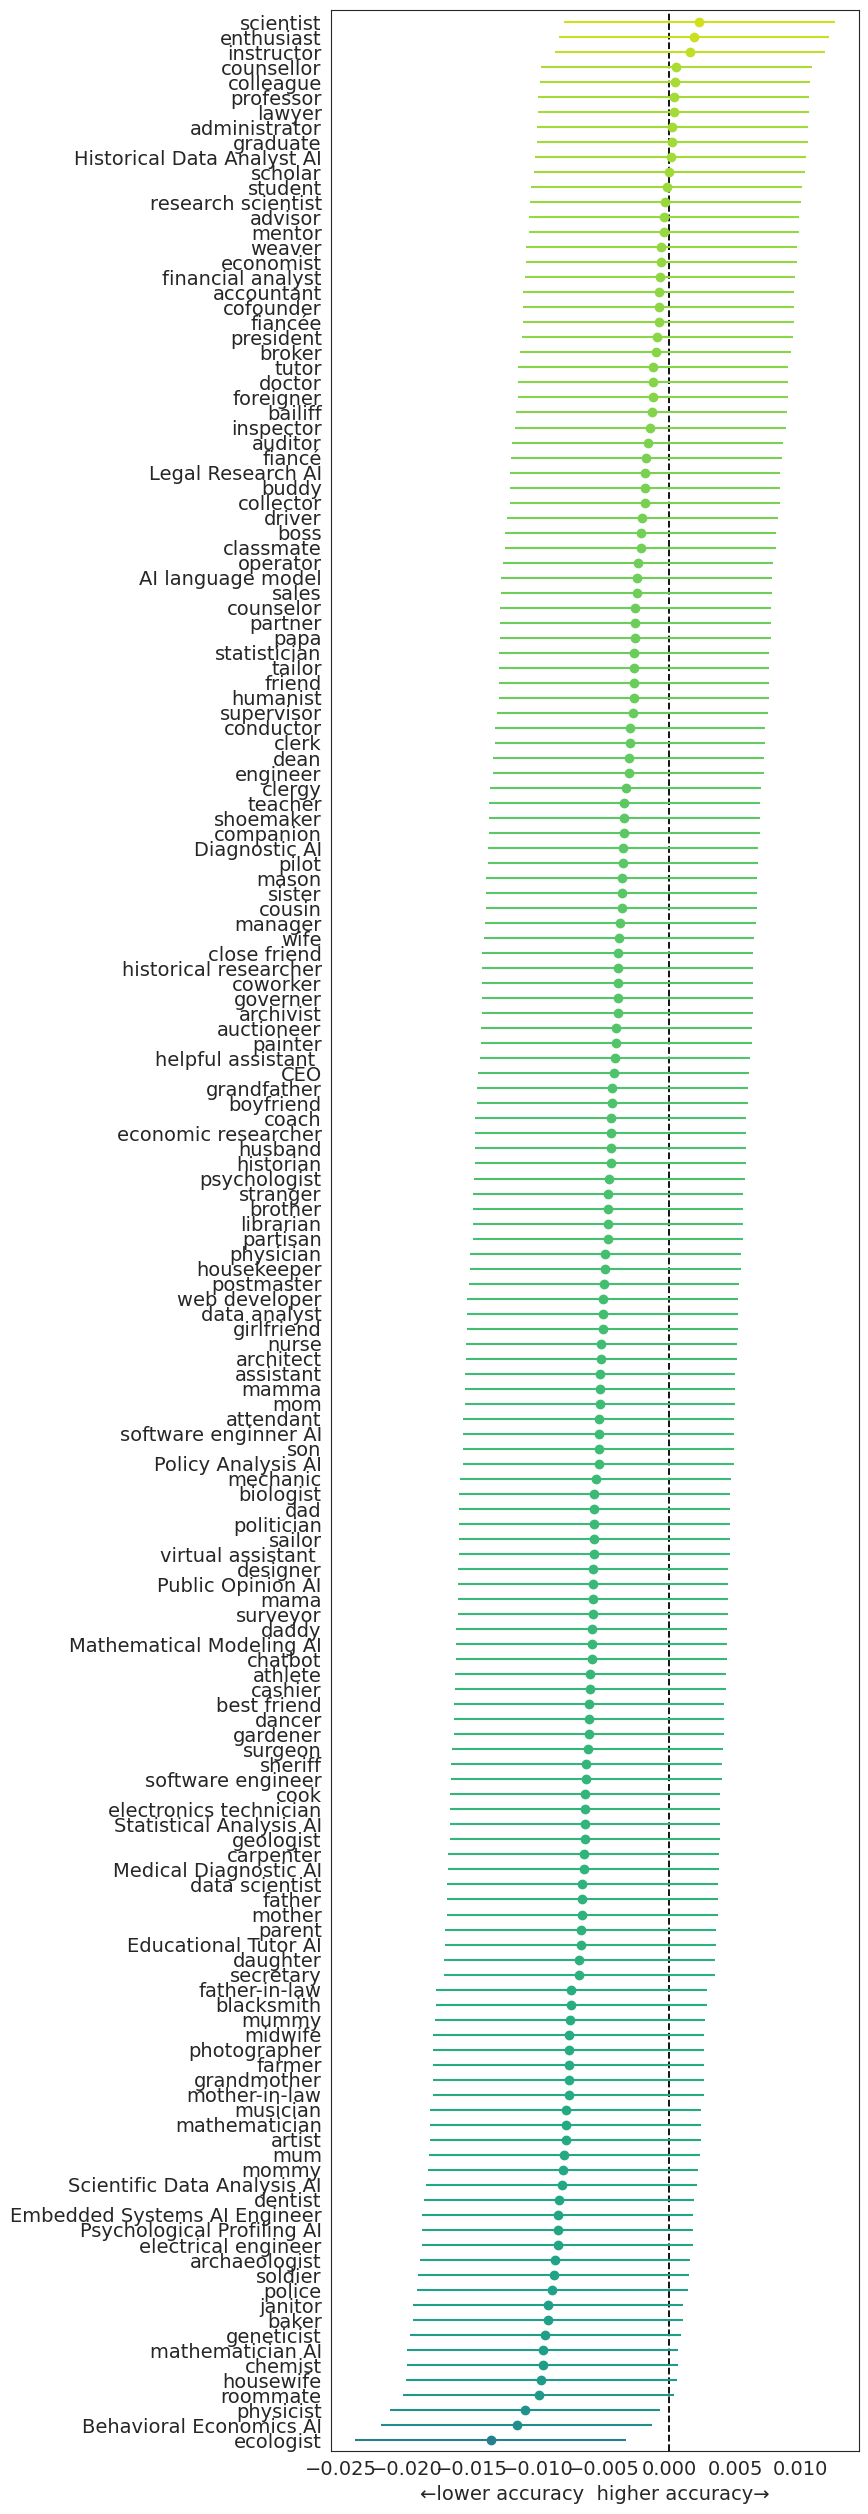

In [269]:
# accuracy ~ role (qwen)

tdf = combined_data[combined_data['model'] == 'qwen2.5-7B']

model = smf.ols("accuracy ~ C(role, Treatment(reference='no role'))", data=tdf)
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)
model_sum_df = model_sum_df.sort_values(by='coeff')

model_sum_df['term'] = model_sum_df['term'].replace({'parents': 'parent',
                                                    'Educational tor AI': 'Educational Tutor AI'})

plot_reg_results(model_sum_df, figsize=(6, 25),
                 xlabel="←lower accuracy  higher accuracy→",
                 filename = '../shared_data/figures/emnlp-CR/acc_role_reg_qwen_appx.pdf')


/tmp/ipykernel_4108145/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


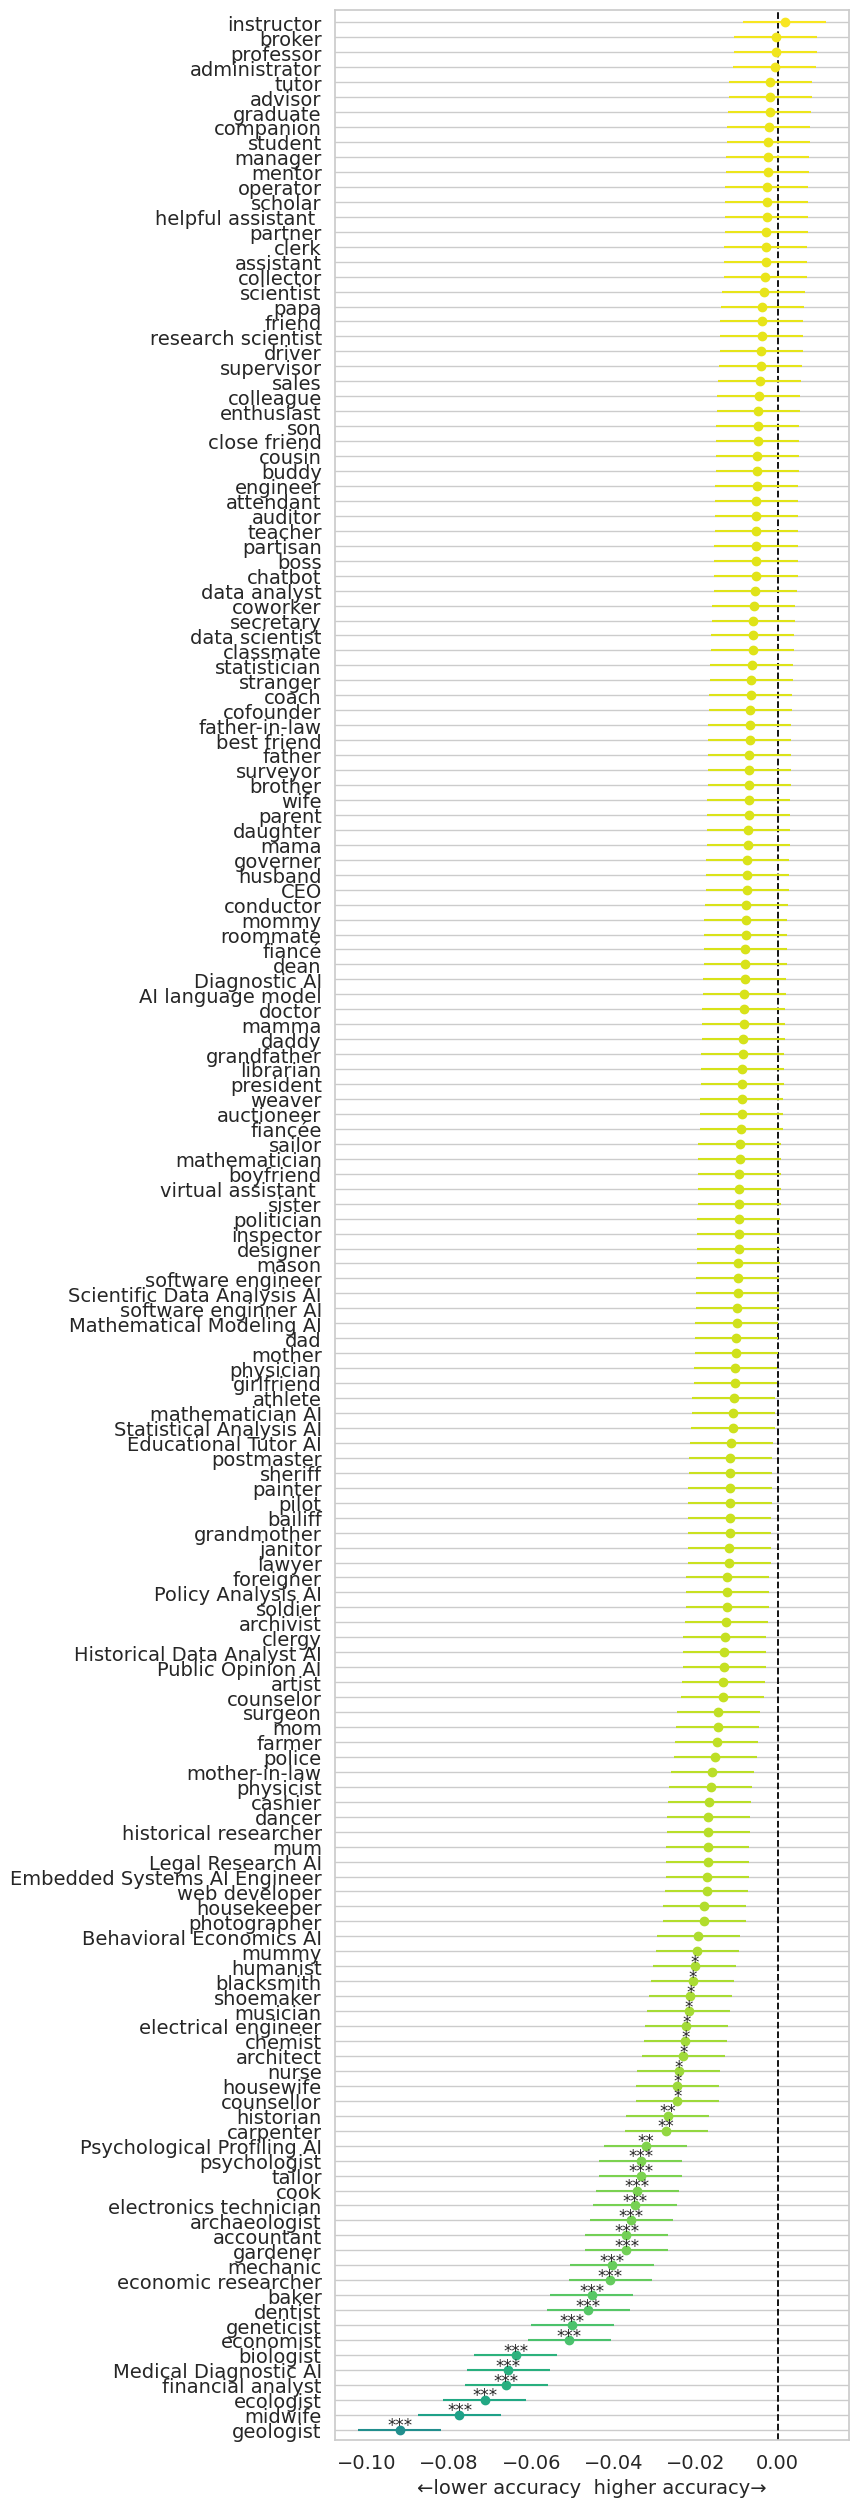

In [273]:
# accuracy ~ role (llama70B)

tdf = combined_data[combined_data['model'] == 'llama3-70B']

model = smf.ols("accuracy ~ C(role, Treatment(reference='no role'))", data=tdf)
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)
model_sum_df = model_sum_df.sort_values(by='coeff')

model_sum_df['term'] = model_sum_df['term'].replace({'parents': 'parent',
                                                    'Educational tor AI': 'Educational Tutor AI'})

plot_reg_results(model_sum_df, figsize=(6, 25),
                 xlabel="←lower accuracy  higher accuracy→",
                 filename = '../shared_data/figures/emnlp-CR/acc_role_reg_llama3-70B_appx.pdf')


/tmp/ipykernel_4108145/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


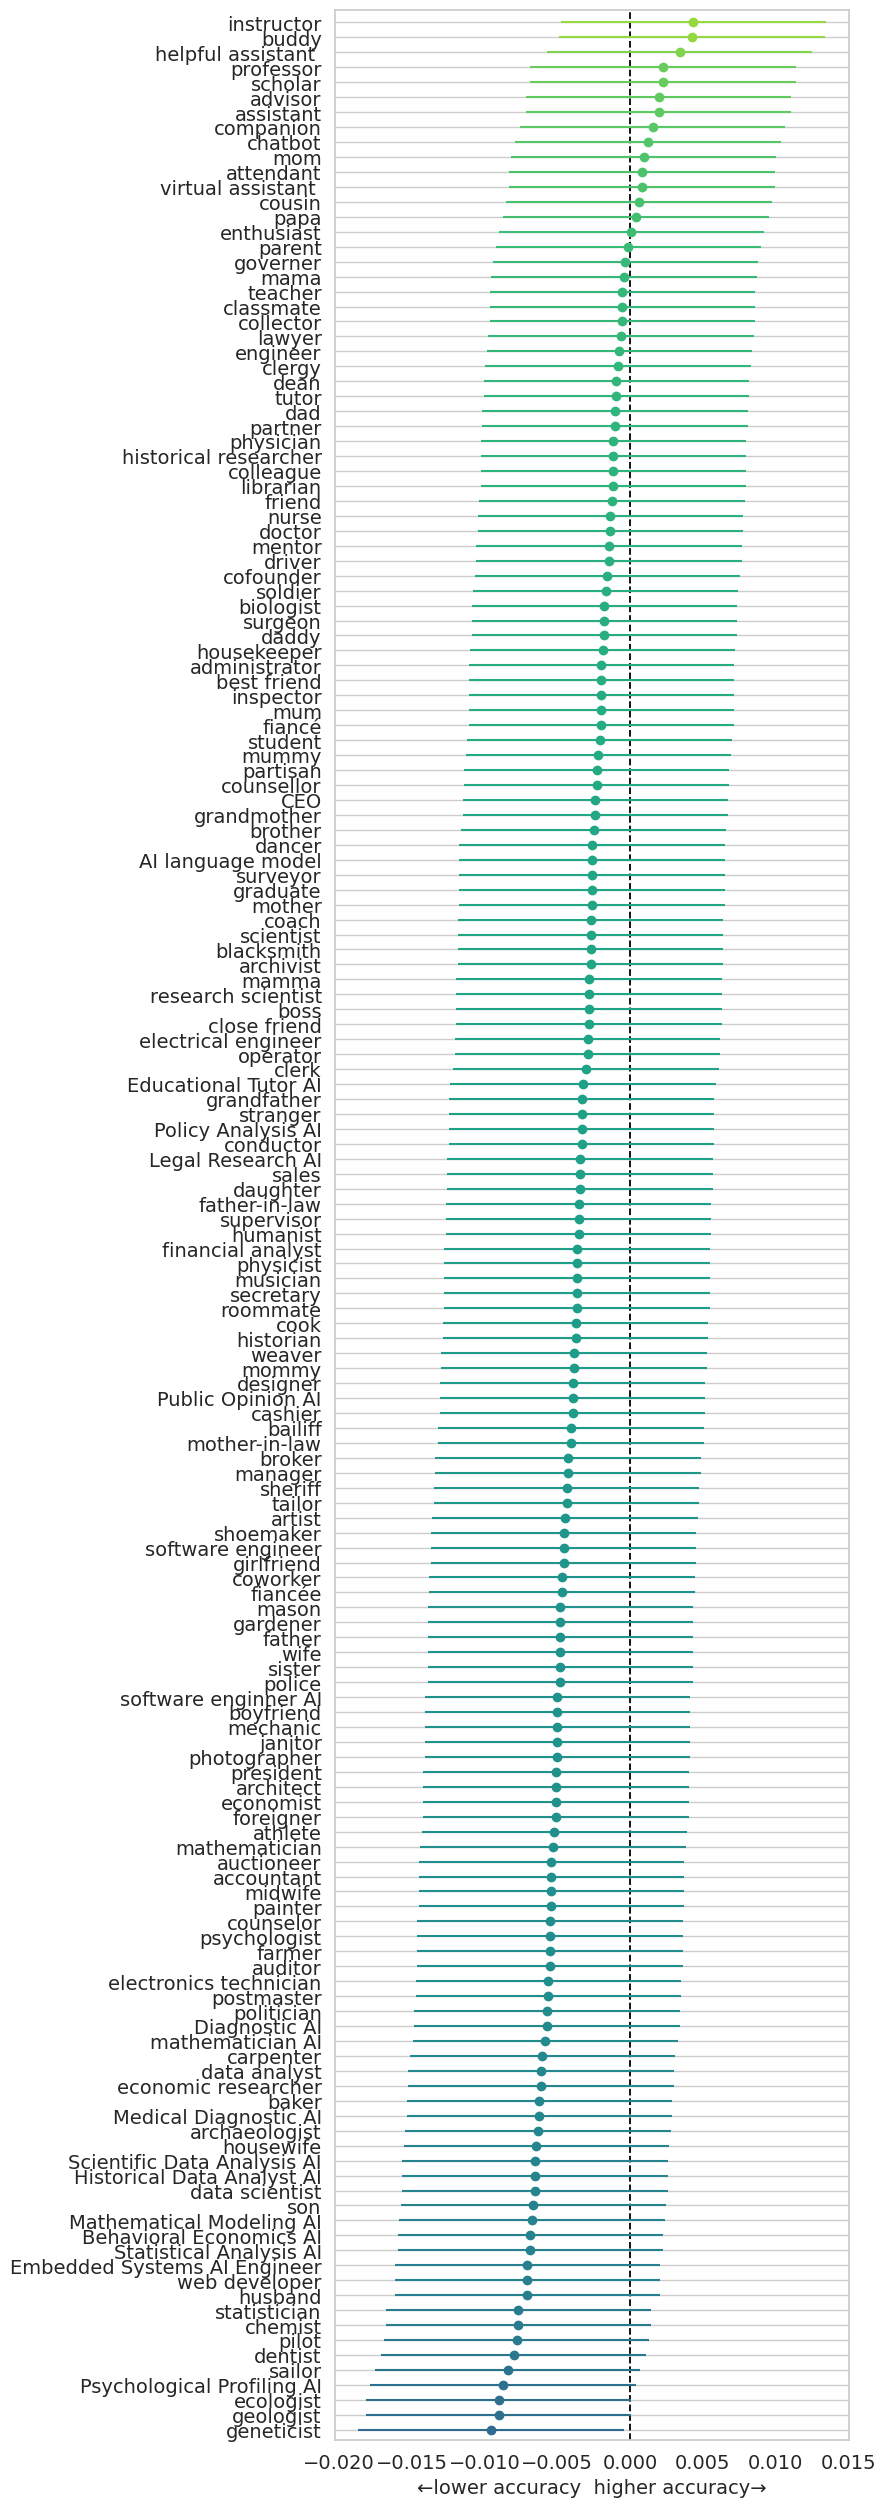

In [272]:
# accuracy ~ role (qwen72B)

tdf = combined_data[combined_data['model'] == 'qwen2.5-72B']

model = smf.ols("accuracy ~ C(role, Treatment(reference='no role'))", data=tdf)
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)
model_sum_df = model_sum_df.sort_values(by='coeff')

model_sum_df['term'] = model_sum_df['term'].replace({'parents': 'parent',
                                                    'Educational tor AI': 'Educational Tutor AI'})

plot_reg_results(model_sum_df, figsize=(6, 25),
                 xlabel="←lower accuracy  higher accuracy→",
                 filename = '../shared_data/figures/emnlp-CR/acc_role_reg_qwen2.5-72B_appx.pdf')


In [81]:
model_sum_df.columns

Index(['index', 'p value', 'coeff', 'SE', 'conf_lower', 'conf_higher', 'term'], dtype='object')

## Count Personas with Negative and No Effect on predicted accuracy

In [298]:
def compute_effect_counts(df, models):
    """
    Perform regression analysis and compute the counts of 'No Effect' and 'Negative Effect' 
    for each model in df.
    
    Args:
        df (pd.DataFrame): The DataFrame for answers.
        models (list): The list of model names to analyze.
        
    Returns:
        pd.DataFrame: A DataFrame with columns 'Model', 'No Effect', and 'Negative Effect'.
    """
    # Initialize lists to store results
    insignificant_counts = []
    negative_counts = []

    # Loop over each model to perform regression and count roles
    for model_name in models:
        tdf = df[df['model'] == model_name]

        # Perform OLS regression
        model = smf.ols(f"accuracy ~ C(role, Treatment(reference='no role'))", data=tdf)
        result = model.fit()

        # Convert results to a DataFrame and clean up terms
        model_sum_df = results_summary_to_dataframe(result)
        model_sum_df = model_sum_df.sort_values(by='coeff')
        model_sum_df['term'] = model_sum_df['term'].replace({'parents': 'parent',
                                                             'Educational tor AI': 'Educational Tutor AI'})

        # Count the number of insignificant roles at significance level 0.1
        insignificant_count = model_sum_df[model_sum_df['p value'] > 0.1].shape[0]
        insignificant_counts.append(insignificant_count)

        # Count the number of negative roles at significance level 0.1 
        negative_count = model_sum_df[(model_sum_df['coeff'] < 0) & (model_sum_df['p value'] < 0.1)].shape[0]
        negative_counts.append(negative_count)

    # Create a DataFrame for the results
    result_df = pd.DataFrame({
        'Model': models,
        'No Effect': insignificant_counts,
        'Negative Effect': negative_counts
    })
    result_df['Positive Effect'] = 162 - result_df['No Effect'] - result_df['Negative Effect']
    
    return result_df

In [299]:
models = ['flan', 'llama3-8B', 'mistral', 'qwen2.5-7B', 'llama3-70B', 'qwen2.5-72B']

model_effect_counts = compute_effect_counts(combined_data, models)


In [300]:
model_effect_counts

Model  No Effect  Negative Effect  Positive Effect
0         flan         44              118                0
1    llama3-8B        143               19                0
2      mistral        153                9                0
3   qwen2.5-7B        162                0                0
4   llama3-70B        119               43                0
5  qwen2.5-72B        162                0                0

In [301]:
qwen_effect_counts = compute_effect_counts(qwen_combined_data, 
                                           ['qwen2.5-0.5B', 'qwen2.5-1.5B', 'qwen2.5-3B', 'qwen2.5-7B', 'qwen2.5-14B', 'qwen2.5-32B', 'qwen2.5-72B'])
qwen_effect_counts

Model  No Effect  Negative Effect  Positive Effect
0  qwen2.5-0.5B        161                0                1
1  qwen2.5-1.5B          0                0              162
2    qwen2.5-3B        158                4                0
3    qwen2.5-7B        162                0                0
4   qwen2.5-14B        162                0                0
5   qwen2.5-32B        162                0                0
6   qwen2.5-72B        162                0                0

In [118]:
effect_counts = pd.concat([model_effect_counts, qwen_effect_counts]).reset_index(drop=True)

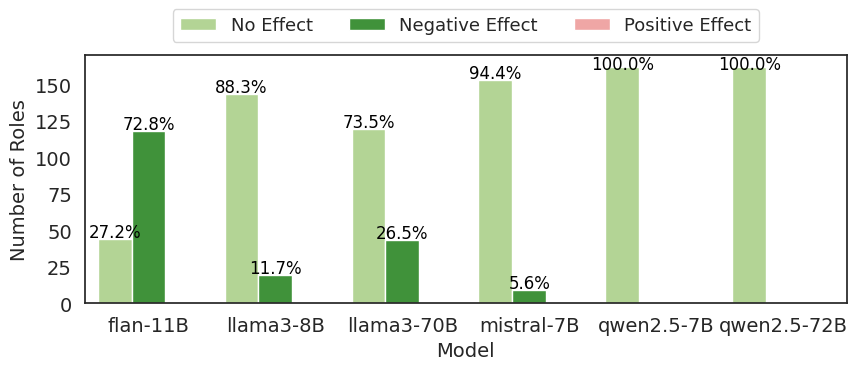

In [320]:
model_plots = ['flan', 'llama3-8B', 'llama3-70B', 'mistral', 'qwen2.5-7B', 'qwen2.5-72B']
tdf = model_effect_counts[model_effect_counts['Model'].isin(model_plots)]

rename_mapping = {'flan': 'flan-11B', 'mistral': 'mistral-7B'}
tdf['Model'] = tdf['Model'].replace(rename_mapping)

# Specify the order of the renamed models
renamed_model_plots = ['flan-11B', 'llama3-8B', 'llama3-70B', 'mistral-7B', 'qwen2.5-7B', 'qwen2.5-72B']

tdf['Model'] = pd.Categorical(tdf['Model'], categories=renamed_model_plots, ordered=True)

plot_data_melted = tdf.melt(id_vars='Model', var_name='Role Type', value_name='Count')

# Plot using seaborn
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8.8, 4))

palette = sns.color_palette("Paired")
light_color = palette[2]
dark_color = palette[3]
positive_color = palette[4] 

sns.barplot(x='Model', y='Count', hue='Role Type', 
            data=plot_data_melted, 
            ax=ax, 
            palette=[light_color, dark_color, positive_color])

for p in ax.patches:
    # Get the total sum of 'No Effect', 'Negative Effect', and 'Positive Effect' for each model
    model = p.get_x()
    model_total = 162
    
    # Compute the percentage based on the model's total
    height = p.get_height()
    percentage_value = (height / model_total) * 100
    percentage = f'{percentage_value:.1f}%'
    
    # Annotate the percentage above each bar
    if percentage_value > 0:
        if percentage_value > 99:
            height = height * 0.98
        ax.annotate(percentage,     
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
    
ax.set_xlabel('Model', fontsize=14)
ax.set_ylabel('Number of Roles', fontsize=14)

# ax.set_title('Number of Insignificant and Negative Roles by Model')
plt.xticks(rotation=0)
plt.legend(fontsize=13, loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=3)

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.savefig('../shared_data/figures/emnlp-CR/role_reg_barplot_percent.pdf', bbox_inches='tight')

In [322]:
qwen_effect_counts

Model  No Effect  Negative Effect  Positive Effect
0  0.5B        161                0                1
1  1.5B          0                0              162
2    3B        158                4                0
3    7B        162                0                0
4   14B        162                0                0
5   32B        162                0                0
6   72B        162                0                0

/tmp/ipykernel_4108145/634831250.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['Model'] = tdf['Model'].str.replace('qwen2.5-', '')
/tmp/ipykernel_4108145/634831250.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['Model'] = pd.Categorical(tdf['Model'], categories=model_order, ordered=True)


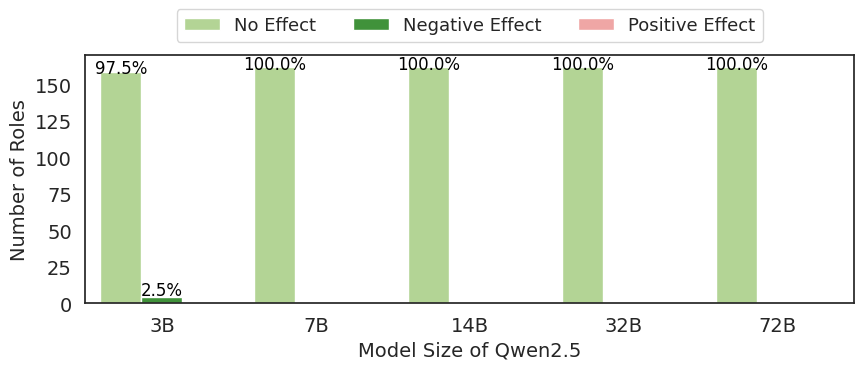

In [326]:
qwen_lst = ['3B', '7B', '14B', '32B', '72B']
tdf = qwen_effect_counts[qwen_effect_counts['Model'].isin(qwen_lst)]

# Remove 'qwen2.5-' prefix from the 'Model' column
tdf['Model'] = tdf['Model'].str.replace('qwen2.5-', '')

model_order = ['3B', '7B', '14B', '32B', '72B']
tdf['Model'] = pd.Categorical(tdf['Model'], categories=model_order, ordered=True)

plot_data_melted = tdf.melt(id_vars='Model', var_name='Role Type', value_name='Count')

# Plot using seaborn
sns.set_style("white")
fig, ax = plt.subplots(figsize=(8.8, 4))

palette = sns.color_palette("Paired")
light_color = palette[2]
dark_color = palette[3]
positive_color = palette[4]

sns.barplot(x='Model', y='Count', hue='Role Type', 
            data=plot_data_melted, 
            ax=ax, 
            palette=[light_color, dark_color, positive_color])

for p in ax.patches:
    model = p.get_x()
    model_total = 162
    
    # Compute the percentage based on the model's total
    height = p.get_height()
    percentage_value = (height / model_total) * 100
    percentage = f'{percentage_value:.1f}%'
    
    # Annotate the percentage above each bar
    if percentage_value > 0:
        if percentage_value > 99:
            height = height * 0.98
        elif percentage_value > 95:
            height = height * 0.99
        ax.annotate(percentage,     
                    (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                    textcoords='offset points')
        
ax.set_xlabel('Model Size of Qwen2.5', fontsize=14)
ax.set_ylabel('Number of Roles', fontsize=14)

# ax.set_title('Number of Insignificant and Negative Roles by Model')
plt.xticks(rotation=0)
plt.legend(fontsize=13, loc='upper center', bbox_to_anchor=(0.5, 1.22), ncol=3)

plt.setp(ax.get_xticklabels(), fontsize=14)
plt.setp(ax.get_yticklabels(), fontsize=14)

plt.tight_layout()
plt.savefig('../shared_data/figures/emnlp-CR/role_reg_barplot_qwen.pdf', bbox_inches='tight')

## accuracy ~ role category + 1|model

In [108]:
combined_data['prompt'].unique()

array(['no role', 'Imagine you are talking to {indefinite} {role}.',
       'You are talking to {indefinite} {role}.',
       'You are {indefinite} {role}.',
       'Imagine you are {indefinite} {role}.'], dtype=object)

/opt/anaconda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_3414007/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


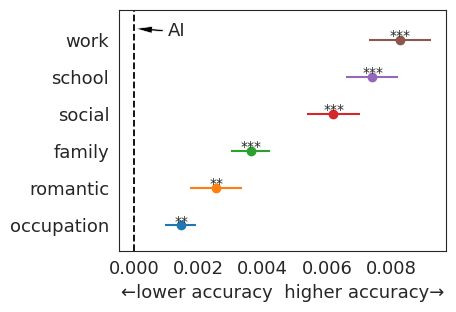

In [275]:
tdf = combined_ans
tdf = pd.merge(tdf, role_df[['role', 'merged_cate']], how='left')
tdf.loc[tdf['merged_cate'].isnull(), 'merged_cate'] = 'no role'

occupation_cate = ['law', 'politics', 'medicine', 'other occupations',
                  'math', 'econ', 'history', 'eecs', 'natural science',
                  'psychology']

# Replace the occupation category 
tdf['merged_cate'] = tdf['merged_cate'].replace(occupation_cate, 'occupation')

model = smf.mixedlm("accuracy ~ C(merged_cate, Treatment(reference='AI'))", data=tdf, groups=tdf['model'], re_formula="1")
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)

plot_reg_results(model_sum_df, figsize=(4,3), labelsize=13,
                 xlabel="←lower accuracy  higher accuracy→",
                 ref="AI", xytext=(0.15,0.95),
                 colors = sns.color_palette()[:7],
                 filename = "../shared_data/figures/emnlp-CR/acc_rolecate_mlm_AI.pdf")

## accuracy ~ prompt + 1|model

In [154]:
combined_data['prompt'].values

array(['no role', 'no role', 'no role', ...,
       'Imagine you are talking to {indefinite} {role}.',
       'You are talking to {indefinite} {role}.',
       'Imagine you are {indefinite} {role}.'], dtype=object)

/opt/anaconda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_3414007/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


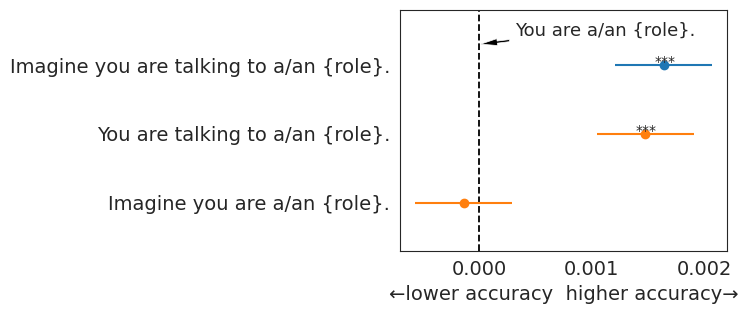

In [276]:
tdf = combined_ans.copy()

tdf['prompt'] = tdf['prompt'].str.replace('{indefinite}', 'a/an')

model = smf.mixedlm("accuracy ~ C(prompt, Treatment(reference='You are a/an {role}.'))", data=tdf, groups=tdf['model'], re_formula="1")
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)

palette = sns.color_palette()
col1 = palette[1]
col2 = palette[0]

plot_reg_results(model_sum_df, figsize=(4,3), 
                 ref="You are a/an {role}.", xytext=(0.35,0.95), 
                 xlabel="←lower accuracy  higher accuracy→", 
                 colors=[col1]*2+[col2]*1,
                 filename="../shared_data/figures/emnlp-CR/acc_prompt_mlm2.pdf")

# II. Social Construct

In [277]:
interpersonal_rolecate = ['family', 'school', 'work', 'romantic', 'social', 'AI']

In [288]:
occupation_lst = role_df[~role_df['merged_cate'].isin(interpersonal_rolecate)]['role'].tolist()
len(occupation_lst)

92

## Gender Impact

In [279]:
male_roles = [
    'brother', 'father', 'daddy', 'dad', 'papa', 'father-in-law', 'grandfather', 
    'husband', 'son', 'boyfriend', 'fiancé'
]

female_roles = [
    'sister', 'mother', 'mummy', 'mamma', 'mommy', 'mom', 'mum', 'mama', 
    'daughter', 'mother-in-law', 'grandmother', 'wife', 'girlfriend', 'fiancée', 
    'housewife'
]

neutral_roles = [
    'professor', 'supervisor', 'instructor', 'student', 'coach', 'tutor', 'dean', 
    'graduate', 'partner', 'classmate', 'companion', 'buddy', 'roommate', 'coworker', 
    'boss', 'colleague', 'mentor', 'friend', 'stranger', 'foreigner', 'best friend', 'close friend', 
    'parents', 'cousin'
]

def categorize_gender(role):
    if role in male_roles:
        return 'male'
    elif role in female_roles:
        return 'female'
    elif role in neutral_roles:
        return 'neutral'
    else:
        return 'unknown'

In [360]:
gender_aligned_words = {'mother': ['mother', 'mamma', 'mom','mother-in-law'],
                        'father': ['daddy', 'dad', 'papa', 'father-in-law'],
                        'boyfriend': ['husband', 'fiancé','boyfriend'],
                        'girlfriend':['wife', 'girlfriend', 'fiancée'],
                        'partner': ['partner'],
                        'parents':['parents']}

gender_role_cate = {'mother': 'parent',
                    'father': 'parent',
                    'parents': 'parent',
                    'partner': 'partner',
                    'boyfriend': 'partner',
                    'girlfriend':'partner'}

def find_align_word(dataset_val):
    for domain, datasets in gender_aligned_words.items():
        if dataset_val in datasets:
            return domain
    return None

role_df['align_words'] = role_df['role'].apply(find_align_word)
role_df['gender_role_cate'] = role_df['align_words'].map(gender_role_cate)

In [361]:
occu_gender_percent = pd.read_csv("../data/occupation_percentages_gender_occ1950.csv")

In [362]:
occu_gender_percent.columns

Index(['Census year', 'Occupation', 'Total Weight', 'Female', 'Male'], dtype='object')

In [363]:
latest_indices = occu_gender_percent.groupby('Occupation')['Census year'].idxmax()
latest_occu_gender_percent = occu_gender_percent.loc[latest_indices]
latest_occu_gender_percent.shape

(124, 5)

In [365]:
role_df = pd.merge(role_df, latest_occu_gender_percent[['Occupation', 'Female', 'Male']], 
                   left_on='role', right_on='Occupation', how='left')

In [366]:
role_df.shape

(162, 13)

In [367]:
role_df[~role_df['Female'].isnull()]['role'].shape

(65,)

In [368]:
combined_ans = pd.merge(combined_ans, 
                        role_df[['role', 'gender', 'align_words', 'gender_role_cate', 'Male']], 
                        how='left')

### 1. explicit gender impact on aligned interpersonal roles

/tmp/ipykernel_4108145/17486043.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tdf['gender'] = tdf['gender'].replace({'male': 'masculine', 'female': 'feminine'})
/opt/anaconda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_4108145/946110898.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(list(df['term']), fontsize=labelsize)


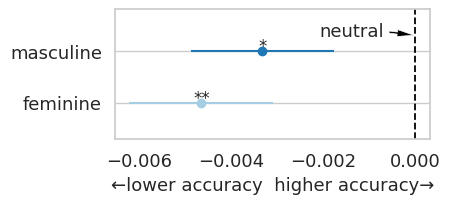

In [373]:
# reference group: neutral 
tdf = combined_ans[~combined_ans['align_words'].isnull()]
# Replace 'male' with 'masculine' and 'female' with 'feminine' in the 'gender' column
tdf['gender'] = tdf['gender'].replace({'male': 'masculine', 'female': 'feminine'})
model = smf.mixedlm("accuracy ~ C(gender, Treatment(reference='neutral'))", 
                    data=tdf, 
                    groups=tdf['model'], 
                    re_formula="1")
result = model.fit()
model_sum_df = results_summary_to_dataframe(result)

palette = sns.color_palette("Paired")

plot_reg_results(model_sum_df, figsize=(4,2),
                 xlabel="←lower accuracy  higher accuracy→",
                 colors = palette[:2], labelsize=13,
                 ref="neutral", xytext=(0.65,0.90),
                filename="../shared_data/figures/emnlp-CR/explicit_gender.pdf")


### 2. Implicit gender impact on occupation roles 

In [370]:
tdf = combined_ans[~combined_ans['Male'].isnull()]
model = smf.mixedlm("accuracy ~ Male", 
                    data=tdf, 
                    groups=tdf['model'], 
                    re_formula="1")
result = model.fit()

fe_params = result.fe_params
conf_int = result.conf_int().loc[fe_params.index]
pvalues = result.pvalues.loc[fe_params.index]

coef_df = pd.DataFrame({
    'term': fe_params.index,
    'coef': fe_params.values,
    'ci_lower': conf_int[0].values,
    'ci_upper': conf_int[1].values,
    'pvalue': pvalues.values
})

/opt/anaconda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


/tmp/ipykernel_4108145/2239696088.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.pointplot(x='coef', y='term', data=coef_df, join=False, capsize=0.2, errwidth=1, ci=None)
/tmp/ipykernel_4108145/2239696088.py:2: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='coef', y='term', data=coef_df, join=False, capsize=0.2, errwidth=1, ci=None)
/tmp/ipykernel_4108145/2239696088.py:2: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(x='coef', y='term', data=coef_df, join=False, capsize=0.2, errwidth=1, ci=None)


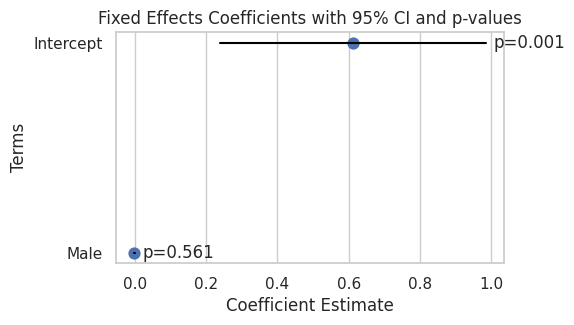

In [371]:
plt.figure(figsize=(5, 3))
sns.pointplot(x='coef', y='term', data=coef_df, join=False, capsize=0.2, errwidth=1, ci=None)
for i in range(coef_df.shape[0]):
    plt.plot([coef_df['ci_lower'][i], coef_df['ci_upper'][i]], [i, i], color='black')
    # Annotating p-values
    plt.text(coef_df['ci_upper'][i] + 0.02, i, f"p={coef_df['pvalue'][i]:.3f}", va='center')

# plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('Fixed Effects Coefficients with 95% CI and p-values')
plt.xlabel('Coefficient Estimate')
plt.ylabel('Terms')
plt.show()

In [372]:
coef_df

term      coef  ci_lower  ci_upper    pvalue
0  Intercept  0.611779  0.238366  0.985192  0.001322
1       Male -0.000579 -0.002534  0.001375  0.561208

In [302]:
result.params

Intercept    0.611779
Male        -0.000579
Group Var    1.000000
dtype: float64

## Domain Impact

Note: there's no dataset under 'history' category due to question length

In [144]:
domain_dic = {'law': ['professional_law', 'international_law'],
             'medicine': ['clinical_knowledge', 'college_medicine', 'professional_medicine'],
             'eecs': ['electrical_engineering', 'college_computer_science', 'high_school_computer_science'],
             'math': ['high_school_statistics', 'college_mathematics', 'high_school_mathematics'],
             'politics': ['us_foreign_policy', 'high_school_government_and_politics'],
             'psychology': ['professional_psychology', 'high_school_psychology'],
             'natural science': ['college_physics', 'college_biology', 'high_school_physics',
                                'high_school_chemistry', 'college_chemistry', 'high_school_biology'],
             'econ': ['management', 'professional_accounting', 'econometrics', 'high_school_macroeconomics', 'high_school_microeconomics']}

def find_domain(dataset_val):
    for domain, datasets in domain_dic.items():
        if dataset_val in datasets:
            return domain
    return None

In [304]:
ques_df = ques_df.assign(
    domain=ques_df['dataset'].apply(lambda x: find_domain(x)))

In [178]:
ques_df['domain'].value_counts()

domain
natural science    570
econ               489
math               284
eecs               247
medicine           221
psychology         200
law                200
politics           199
Name: count, dtype: int64

In [153]:
for model_name, ans_df in model_ans_dic.items():
    model_ans_dic[model_name] = ans_df.assign(
        domain=ans_df['dataset'].apply(lambda x: find_domain(x)),
        in_domain=ans_df.apply(lambda row: 1 if find_domain(row['dataset']) == row['merged_cate'] else 0, axis=1)
    )

/opt/anaconda/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2261: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)
/tmp/ipykernel_3414007/1198796317.py:19: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  sns.pointplot(x='coef', y='term', data=coef_df, join=False, capsize=0.2, errwidth=1, errorbar=None)
/tmp/ipykernel_3414007/1198796317.py:19: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  sns.pointplot(x='coef', y='term', data=coef_df, join=False, capsize=0.2, errwidth=1, errorbar=None)


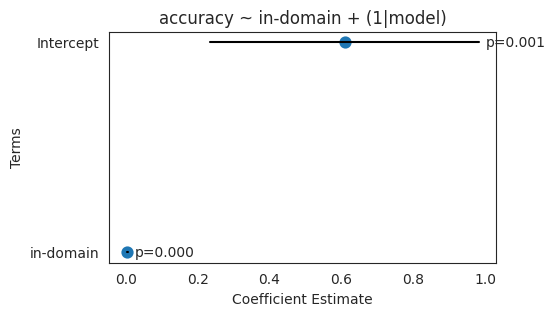

In [306]:
tdf = pd.concat(list(model_ans_dic.values()), axis=0)[lambda df: df['merged_cate'].isin(domain_dic.keys())]

model = smf.mixedlm("accuracy ~ C(in_domain, Treatment(reference='out-domain'))", data=tdf, groups=tdf['model'], re_formula="1")
result = model.fit()

fe_params = result.fe_params
conf_int = result.conf_int().loc[fe_params.index]
pvalues = result.pvalues.loc[fe_params.index]

coef_df = pd.DataFrame({
    'term': ['Intercept', 'in-domain'],
    'coef': fe_params.values,
    'ci_lower': conf_int[0].values,
    'ci_upper': conf_int[1].values,
    'pvalue': pvalues.values
})

plt.figure(figsize=(5, 3))
sns.pointplot(x='coef', y='term', data=coef_df, join=False, capsize=0.2, errwidth=1, errorbar=None)
for i in range(coef_df.shape[0]):
    plt.plot([coef_df['ci_lower'][i], coef_df['ci_upper'][i]], [i, i], color='black')
    # Annotating p-values
    plt.text(coef_df['ci_upper'][i] + 0.02, i, f"p={coef_df['pvalue'][i]:.3f}", va='center')

# plt.axvline(0, color='black', linewidth=0.8, linestyle='--')
plt.title('accuracy ~ in-domain + (1|model)')
plt.xlabel('Coefficient Estimate')
plt.ylabel('Terms')
plt.show()

In [307]:
coef_df

term      coef  ci_lower  ci_upper    pvalue
0  Intercept  0.608870  0.234997  0.982742  0.001413
1  in-domain  0.004013  0.001975  0.006050  0.000114

# III. Model Variety

In [308]:
model_ans_dic['flan'].columns

Index(['model', 'role', 'merged_cate', 'mmlu', 'prompt', 'question_id',
       'dataset', 'accuracy', 'full_question', 'domain', 'in_domain'],
      dtype='object')

In [312]:
test_ques_df.shape

(462, 13)

In [58]:
# select answer results for questions in the test set
testset_df_dic = {}
for model_name, ans_df in model_ans_dic.items():
    testset_df_dic[model_name] = pd.merge(ans_df[['dataset', 'full_question', 'role', 'prompt', 'accuracy']], 
                                          test_ques_df[['dataset', 'full_question']]) 

In [314]:
testset_df_dic['qwen2.5-7B'].shape

(299376, 5)

## Frequency

In [315]:
testset_df_dic['flan'].columns

Index(['dataset', 'full_question', 'role', 'prompt', 'accuracy'], dtype='object')

In [317]:
role_df.columns

Index(['role', 'role cate', 'occupation cate', 'merged_cate',
       'N-gram Frequency (2018-2019)', 'mmlu', 'interpersonal', 'gender',
       'align_words', 'gender_role_cate', 'Occupation', 'Female', 'Male'],
      dtype='object')

In [123]:
testset_freq_dic = {}
models = ['flan', 'llama3-8B', 'mistral', 'qwen2.5-7B', 'llama3-70B', 'qwen2.5-72B']

for m in models:
    testset_df = testset_df_dic[m]
    freq_df = pd.merge(testset_df, 
                      role_df[['role','N-gram Frequency (2018-2019)', 'merged_cate']], 
                      how='left')
    freq_df['model'] = m 
    
    role_dataset_acc_mean = testset_df.groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    role_dataset_acc_freq_merged = pd.merge(role_dataset_acc_mean, 
                                            role_df[['role','N-gram Frequency (2018-2019)', 'merged_cate']],
                                            how='left')
    test_freq = role_dataset_acc_freq_merged.groupby(['role','merged_cate'])[['accuracy', 'N-gram Frequency (2018-2019)']].mean().reset_index()
    test_freq['model'] = m
    
    testset_freq_dic[m] = {'freq': freq_df, 
                          'role_mean': test_freq}

In [335]:
def plot_test_acc_freq(testset_result_dic, models, file_name=None):
    occupation_categories = set(['econ', 'eecs', 'history', 'law', 'math', 'medicine', 'natural science', 'other occupations', 'politics', 'psychology'])
    model_name_mapping = {'flan': 'flan-11B', 'mistral': 'mistral-7B'}
    freq_combined_df = (
        pd.concat([m['role_mean'] for m in testset_result_dic.values()], ignore_index=True)
        .query("`N-gram Frequency (2018-2019)` != 0")
        .assign(
            cate=lambda df: df['merged_cate'].apply(lambda x: 'occupation' if x in occupation_categories else x),
            role=lambda df: df['role'].astype('category'),
            model=lambda df: df['model'].replace(model_name_mapping).astype('category'),
            merged_cate=lambda df: df['merged_cate'].astype('category')
        )
    )
    
    markers = ['o', 's', 'D', '^', 'p', 'X', 'P', '*']

    categories = freq_combined_df['cate'].unique()

    default_palette = sns.color_palette()
    num_models = len(models)
    base_colors = [default_palette[i % len(default_palette)] for i in range(num_models)]

    sns.set(style="whitegrid")

    # Initialize a matplotlib figure for combining plots
    plt.figure(figsize=(8, 6))

    for i, model in enumerate(models):
        model_df = freq_combined_df[freq_combined_df['model'] == model]
        for j, category in enumerate(categories):
            # Filter the DataFrame for the current model and category
            category_df = model_df[model_df['cate'] == category]
            altered_color = alter_color(base_colors[i], 1 - j * 0.05)
            label = category if i == 0 else "_nolegend_"
            # Plot each category with a specific marker
            plt.scatter(category_df['N-gram Frequency (2018-2019)'], category_df['accuracy'], 
                        marker=markers[j % len(markers)], alpha=0.2, color=altered_color,
                        label=label)

    text_y_position = 0.15
    # Overlay regression lines for each model
    texts = []
    for i, model in enumerate(models):
        model_df = freq_combined_df[freq_combined_df['model'] == model]
        sns.regplot(x='N-gram Frequency (2018-2019)', y='accuracy', data=model_df, 
                    scatter=False, color=base_colors[i],
                    label=f'{model}')
        correlation = model_df['N-gram Frequency (2018-2019)'].corr(model_df['accuracy'])
        x_min = model_df['N-gram Frequency (2018-2019)'].min()
        x_shifted_left = x_min * 1.05
        
        x_median = model_df['N-gram Frequency (2018-2019)'].median()
        y_median = np.polyval(np.polyfit(model_df['N-gram Frequency (2018-2019)'], 
                                      model_df['accuracy'], 1), x_median)

        y_offset = (max(model_df['accuracy']) - min(model_df['accuracy'])) * 0.05 
        y_position_for_annotation = y_median + y_offset

        darker_color = darken_color(base_colors[i])
        
        plt.text(x_shifted_left, y_position_for_annotation, f'{model}: ρ={correlation:.2f}', 
                 horizontalalignment='left', verticalalignment='bottom',
                 color=darker_color, fontsize=12)

        text_y_position -= 0.05

    legend_elements = [plt.Line2D([0], [0], marker=markers[j % len(markers)], color='w', 
                                  markerfacecolor='grey', label=category, markersize=10)
                       for j, category in enumerate(categories)]

    legend = plt.legend(handles=legend_elements, title='Role Category', 
                        loc='upper right', bbox_to_anchor=(1.01, 1.22),fontsize=13, ncol=4)

    legend.set_title(title='Role Category', prop={'size': 13})

    plt.xlabel('Log-scaled N-gram Frequency in 2018-2019', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.gca().set_xscale('log')
    
    if file_name:
        ensure_directory(file_name)
        plt.savefig(file_name, bbox_inches='tight')

    plt.show()  

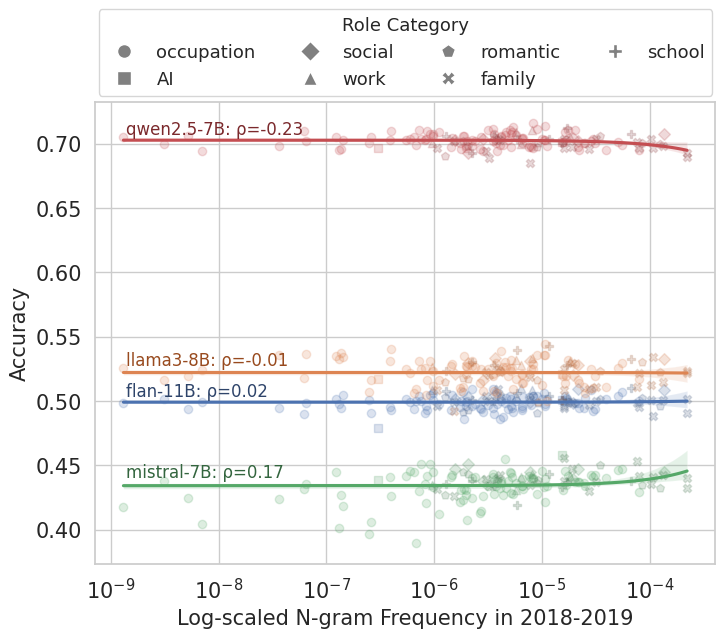

In [336]:
plot_test_acc_freq(testset_freq_dic,
                   models = ['flan-11B', 'llama3-8B', 'mistral-7B', 'qwen2.5-7B'])

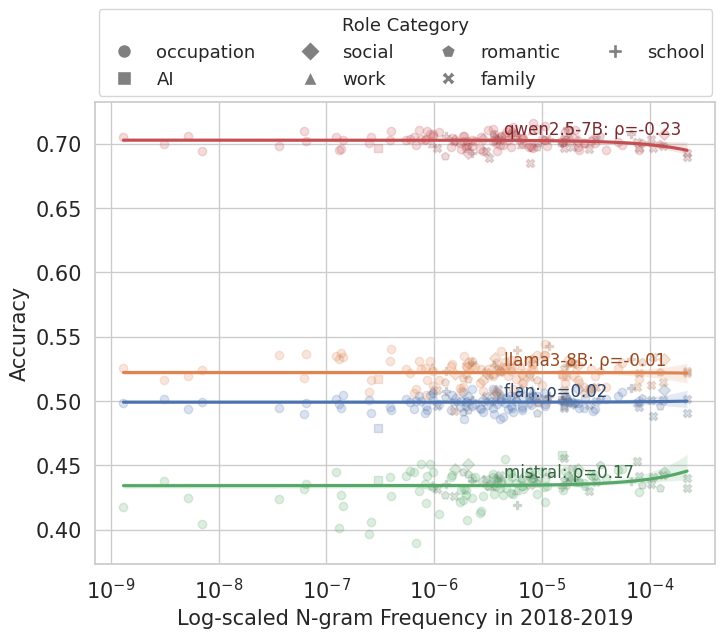

In [338]:
plot_test_acc_freq(testset_freq_dic,
                   models = ['flan', 'llama3-8B', 'mistral', 'qwen2.5-7B'],
                  file_name = "../shared_data/figures/emnlp-CR/frequency_midsize.pdf")

In [331]:
list(testset_freq_dic.keys())

['flan', 'llama3-8B', 'mistral', 'qwen2.5-7B', 'llama3-70B', 'qwen2.5-72B']

In [390]:
testset_freq_dic['flan']['freq'].shape

(299376, 8)

In [392]:
299376/162/4

462.0

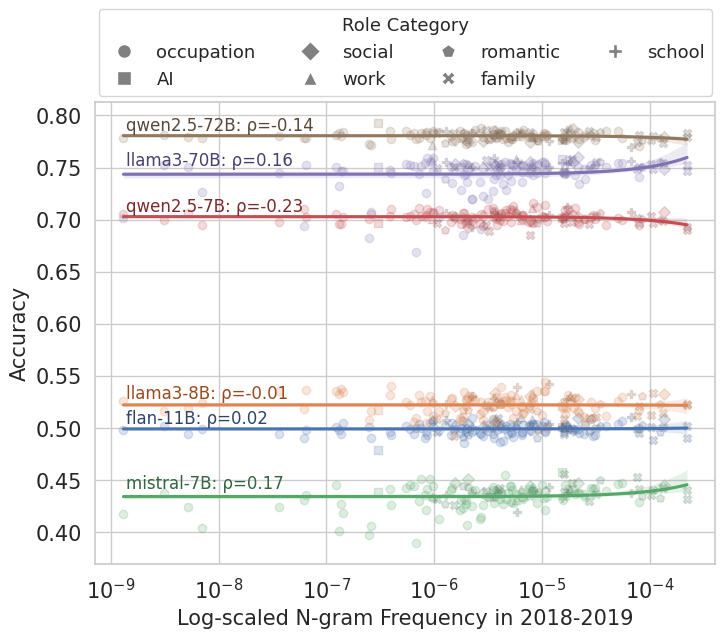

In [337]:
plot_test_acc_freq(testset_freq_dic,
                   models=['flan-11B', 'llama3-8B', 'mistral-7B', 'qwen2.5-7B', 'llama3-70B', 'qwen2.5-72B'],
                  file_name = "../shared_data/figures/emnlp-CR/frequency_all.pdf")

## Perplexity

In [85]:
exclude_prompts = ['Imagine you are talking to your {relationship}. {question_text}',
                  'You are talking to your {relationship}. {question_text}']

def remove_extra_periods(text):
    # Define the pattern to match 'number. text.'
    pattern = r'(\d+\.\s[^.]*?)\.,'
    # Replace the matched pattern with 'number. text,'
    cleaned_text = re.sub(pattern, r'\1,', text)
    # Remove the trailing period if it exists at the end of the string
    cleaned_text = re.sub(r'\.,', r',', cleaned_text)
    # Remove any remaining trailing period at the end of the text
    cleaned_text = re.sub(r'\.$', '', cleaned_text)
    return cleaned_text

def extract_role_and_template(prompt):
    role = None
    template = None

    if re.search(r'Imagine you are an? ', prompt, re.IGNORECASE):
        role = re.search(r'Imagine you are an? (.+?)\.', prompt, re.IGNORECASE).group(1)
        template = 'Imagine you are {indefinite} {role}.'
    elif re.search(r'You are an? ', prompt, re.IGNORECASE):
        role = re.search(r'You are an? (.+?)\.', prompt, re.IGNORECASE).group(1)
        template = 'You are {indefinite} {role}.'
    elif re.search(r'Imagine you are talking to an? ', prompt, re.IGNORECASE):
        role = re.search(r'Imagine you are talking to an? (.+?)\.', prompt, re.IGNORECASE).group(1)
        template = 'Imagine you are talking to {indefinite} {role}.'
    elif re.search(r'You are talking to an? ', prompt, re.IGNORECASE):
        role = re.search(r'You are talking to an? (.+?)\.', prompt, re.IGNORECASE).group(1)
        template = 'You are talking to {indefinite} {role}.'

    return role, template

In [82]:
path = "../data/testset_full_prompt.csv"
ppl_raw_df = pd.read_csv(path)
ppl_raw_df['full_question'] = ppl_raw_df['full_question'].apply(remove_extra_periods)

# ppl_df = ppl_df[~ppl_df['prompt'].isin(exclude_prompts)]
# ppl_df[['full_prompt', 'full_question', 'dataset']].to_csv("../data/testset_full_prompt.csv", index=False)

In [83]:
ppl_raw_df['full_question'].str.endswith("..").sum()

0

In [343]:
speaker_prompts = ['Imagine you are {indefinite} {role}.', 'You are {indefinite} {role}.']

audience_prompts = ['Imagine you are talking to {indefinite} {role}.', 
                    'You are talking to {indefinite} {role}.']

speaker_prompts + audience_prompts

['Imagine you are {indefinite} {role}.',
 'You are {indefinite} {role}.',
 'Imagine you are talking to {indefinite} {role}.',
 'You are talking to {indefinite} {role}.']

In [81]:
testset_df_dic['flan'].columns

Index(['dataset', 'full_question', 'role', 'prompt', 'accuracy'], dtype='object')

In [281]:
testset_ppl_path_dic = {'flan': "../data/perplexity/flan_lmppl_testset_full.csv",
                        'llama3-8B': "../data/perplexity/llama3_lm_lmppl_testset.csv",
                        'mistral': "../data/perplexity/mistral_lm_lmppl_testset.csv",
                        'qwen2.5-7B': "../data/perplexity/updated/qwen2.5_7B_ppl_testset.csv", # qwen2.5 to be updated
                       }

model_ppl_dic = {}
for m, ppl_path in testset_ppl_path_dic.items():
    testset_df = testset_df_dic[m]
    ppl_df = pd.read_csv(ppl_path)
    ppl_df['model'] = m
    ppl_df['full_question'] = ppl_df['full_question'].apply(remove_extra_periods)
    
    if m != 'flan':
        ppl_df[['role', 'prompt']] = ppl_df['full_prompt'].apply(lambda x: pd.Series(extract_role_and_template(x)))
        ppl_df = pd.merge(ppl_df, ppl_raw_df, how='left')
        ppl_df = pd.merge(ppl_df, testset_df, how='left')
    else: 
        ppl_df = ppl_df.rename(columns={'prompt_ques_ppl_flan': 'prompt_ques_ppl'})
        ppl_df = ppl_df[~ppl_df['prompt'].isin(exclude_prompts)]
        ppl_df['prompt'] = ppl_df['prompt'].str.replace('{relationship}. {question_text}', '{role}.')
        
    ppl_role_mean_df = ppl_df[['dataset', 'role', 'full_question', 'accuracy', 'prompt_ques_ppl']].groupby(['role', 'dataset'])[['prompt_ques_ppl', 'accuracy']].mean().reset_index()
    ppl_role_mean_df['model'] = m
    ppl_role_mean_df.rename(columns={'prompt_ques_ppl': 'ppl'}, inplace=True)
    ppl_role_mean_df = pd.merge(ppl_role_mean_df, role_df[['role', 'merged_cate']], how='left')
    
    model_ppl_dic[m] = {'ppl': ppl_df,
                       'role_mean': ppl_role_mean_df}

/tmp/ipykernel_4108145/3357027553.py:10: DtypeWarning: Columns (13,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  ppl_df = pd.read_csv(ppl_path)


In [282]:
model_ppl_dic['qwen2.5-7B']['ppl']['accuracy'].value_counts()

accuracy
1.0    14125
0.0     5963
Name: count, dtype: int64

In [358]:
def plot_test_acc_ppl(testset_result_dic, models, file_name=None):
    tdf = pd.concat([m['role_mean'] for m in testset_result_dic.values()])
    tdf_role = tdf.groupby(['role','model'])[['ppl', 'accuracy']].mean().reset_index()
    tdf_role = pd.merge(tdf_role, role_df[['role', 'merged_cate']], how='left')
    
    model_name_mapping = {'flan': 'flan-11B', 'mistral': 'mistral-7B'}
    tdf_role['model'] = tdf_role['model'].replace(model_name_mapping)
    
    min_ppl = tdf_role.groupby('model')['ppl'].transform('min')
    max_ppl = tdf_role.groupby('model')['ppl'].transform('max')

    tdf_role['rescaled_ppl'] = (tdf_role['ppl'] - min_ppl) / (max_ppl - min_ppl)

    occupation_categories = ['econ', 'eecs', 'history', 'law', 'math', 'medicine', 'natural science', 'other occupations', 'politics', 'psychology']
    tdf_role['cate'] = tdf_role['merged_cate'].apply(lambda x: 'occupation' if x in occupation_categories else x)
    tdf_role['role'] = tdf_role['role'].astype('category')
    tdf_role['model'] = tdf_role['model'].astype('category')
    tdf_role['merged_cate'] = tdf_role['merged_cate'].astype('category')

    markers = ['o', 's', 'D', '^', 'p', 'X', 'P', '*']

    categories = tdf_role['cate'].unique()

    # base_colors = sns.color_palette("hsv", len(models))
    default_palette = sns.color_palette()
    num_models = len(models)
    base_colors = [default_palette[i % len(default_palette)] for i in range(num_models)]

    sns.set(style="whitegrid")

    # Initialize a matplotlib figure for combining plots
    plt.figure(figsize=(8, 6))

    for i, model in enumerate(models):
        model_df = tdf_role[tdf_role['model'] == model]
        for j, category in enumerate(categories):
            # Filter the DataFrame for the current model and category
            category_df = model_df[model_df['cate'] == category]
            altered_color = alter_color(base_colors[i], 1 - j * 0.05)
            label = category if i == 0 else "_nolegend_"
            # Plot each category with a specific marker
            plt.scatter(category_df['rescaled_ppl'], category_df['accuracy'], 
                        marker=markers[j % len(markers)], alpha=0.2, color=altered_color,
                        label=label)

    text_y_position = 0.15
    # Overlay regression lines for each model
    for i, model in enumerate(models):
        model_df = tdf_role[tdf_role['model'] == model]
        sns.regplot(x='rescaled_ppl', y='accuracy', data=model_df, 
                    scatter=False, color=base_colors[i],
                    label=f'{model}')
        
        correlation = model_df['rescaled_ppl'].corr(model_df['accuracy'])
        
        slope, intercept = np.polyfit(model_df['rescaled_ppl'], model_df['accuracy'], 1)
        
        x_median = model_df['rescaled_ppl'].median()
        x_min = model_df['rescaled_ppl'].min()
        x_max = model_df['rescaled_ppl'].max()
#         y_median = model_df['accuracy'].median()
        y_median = slope * x_median + intercept
        darker_color = darken_color(base_colors[i])

#         y_position_for_annotation = y_median - (max(model_df['accuracy']) - min(model_df['accuracy'])) * 0.55

        plt.text(x_max*0.7, y_median+0.004, f'{model}: ρ={correlation:.2f}', 
                 horizontalalignment='left', verticalalignment='bottom',
                 color=darker_color, fontsize=12)

        # Update the y position for the next text
        text_y_position -= 0.05

    # plt.legend(title='Model',loc='upper right')
    legend_elements = [plt.Line2D([0], [0], marker=markers[j % len(markers)], color='w', 
                                  markerfacecolor='grey', label=category, markersize=10)
                       for j, category in enumerate(categories)]
    legend = plt.legend(handles=legend_elements, title='Role Category', loc='upper right', 
                        bbox_to_anchor=(1.01, 1.22),fontsize=13, ncol=4)

    legend.set_title(title='Role Category', prop={'size': 12})

    plt.xlabel('Rescaled Perplexity', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)

    if file_name:
        ensure_directory(file_name)
        plt.savefig(file_name, bbox_inches='tight')

    plt.show() 

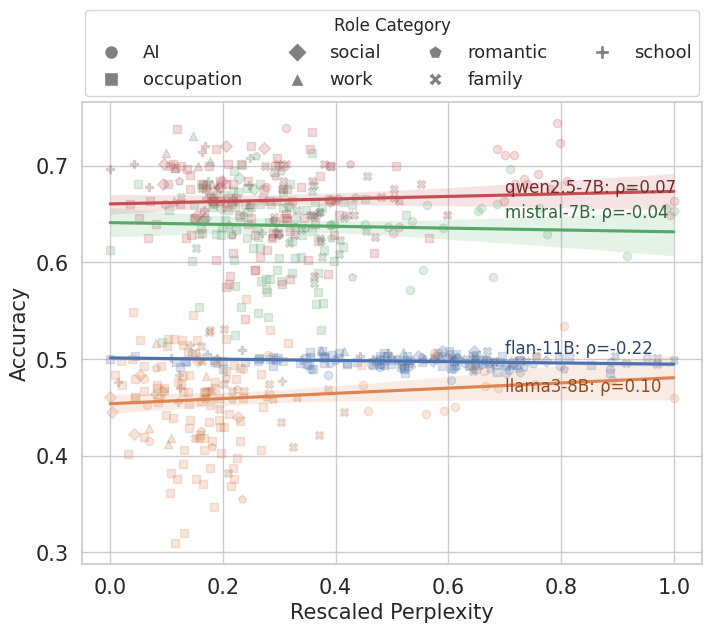

In [359]:
plot_test_acc_ppl(model_ppl_dic, models=['flan-11B', 'llama3-8B', 'mistral-7B', 'qwen2.5-7B'],
                  file_name = "../shared_data/figures/emnlp-CR/perplexity_midsize.pdf")

## Similarity

In [403]:
def get_indefinite_article(word):
    if word[0].lower() in 'aeiou':
        return 'an'
    else:
        return 'a'

In [416]:
'''
Prepare input file for similarity computation
'''
# tdf = model_ans_dic['qwen2.5-7B'].copy()
# sim_df = tdf[['role', 'prompt', 'full_question']].drop_duplicates().reset_index(drop=True)
# sim_df['context_prompt'] = sim_df.apply(lambda row: row['prompt'].replace('{indefinite}', get_indefinite_article(row['role'])).replace('{role}', row['role']), axis=1)
# sim_df.to_csv("../data/similarity_input_final.csv", index=False)

In [90]:
sim_all_ques = pd.read_csv("../data/similarity_result_all.csv")
sim_all_ques.shape

(1561680, 5)

In [92]:
sim_all_ques.columns

Index(['role', 'prompt', 'full_question', 'context_prompt', 'prompt_ques_sim'], dtype='object')

In [93]:
sim_testset = sim_all_ques[sim_all_ques['full_question'].isin(test_ques_df['full_question'])]

In [163]:
sim_testset = pd.merge(sim_testset, test_ques_df[['full_question', 'dataset']], how='left')

In [98]:
model_sim_dic = {}
for m, ans_df in testset_df_dic.items():
    sim_df = pd.merge(sim_testset[['role','prompt','full_question', 'prompt_ques_sim']], 
                      ans_df[['full_question','dataset', 'role','prompt','accuracy']], 
                      how='left')
    sim_df = pd.merge(sim_df, role_df[['role', 'merged_cate']], how='left')
    
    sim_df['model'] = m 
    sim_role_mean = sim_df.groupby(['role', 'dataset'])[['prompt_ques_sim', 'accuracy']].mean().reset_index()
    sim_role_mean = pd.merge(sim_role_mean, role_df[['role', 'merged_cate']], how='left')
    sim_role_mean['model'] = m 
    
    print(f"{m} done!")   
    model_sim_dic[m] = {'sim': sim_df,
                       'sim_role_mean': sim_role_mean}

flan done!
llama3-8B done!
mistral done!
qwen2.5-7B done!
qwen2.5-72B done!
llama3-70B done!


In [99]:
tdf = model_sim_dic['flan']['sim']
_sim = tdf['prompt_ques_sim'].max()
tdf[tdf['prompt_ques_sim']==_sim]

role                                           prompt  \
267168  lawyer  Imagine you are talking to {indefinite} {role}.   

                                            full_question  prompt_ques_sim  \
267168  In which of these situations are the communica...         0.491315   

                 dataset  accuracy merged_cate model  
267168  professional_law         0         law  flan

In [113]:
model_sim_dic['flan']['sim_role_mean'].columns

Index(['role', 'dataset', 'prompt_ques_sim', 'accuracy', 'merged_cate',
       'model'],
      dtype='object')

In [350]:
def plot_test_acc_sim(testset_result_dic, models, file_name=None):
    model_name_mapping = {'flan': 'flan-11B', 'mistral': 'mistral-7B'}
    
    tdf = pd.concat([m['sim_role_mean'] for m in testset_result_dic.values()], ignore_index=True)
    
    tdf_role = tdf.groupby(['role','model'])[['prompt_ques_sim', 'accuracy']].mean().reset_index()
    tdf_role = pd.merge(tdf_role, role_df[['role', 'merged_cate']], how='left')
    tdf_role['model'] = tdf_role['model'].replace(model_name_mapping)
    
    occupation_categories = ['econ', 'eecs', 'history', 'law', 'math', 'medicine', 'natural science', 'other occupations', 'politics', 'psychology']
    tdf_role['cate'] = tdf_role['merged_cate'].apply(lambda x: 'occupation' if x in occupation_categories else x)

    tdf_role['role'] = tdf_role['role'].astype('category')
    tdf_role['model'] = tdf_role['model'].astype('category')
    tdf_role['merged_cate'] = tdf_role['merged_cate'].astype('category')

    markers = ['o', 's', 'D', '^', 'p', 'X', 'P', '*']

    categories = tdf_role['cate'].unique()
    # models = ['llama', 'flan', 'mistral', 'qwen']

    # base_colors = sns.color_palette("hsv", len(models))
    default_palette = sns.color_palette()
    num_models = len(models)
    base_colors = [default_palette[i % len(default_palette)] for i in range(num_models)]

    sns.set(style="whitegrid")
    plt.figure(figsize=(8, 6))

    for i, model in enumerate(models):
        model_df = tdf_role[tdf_role['model'] == model]
        for j, category in enumerate(categories):
            category_df = model_df[model_df['cate'] == category]
            altered_color = alter_color(base_colors[i], 1 - j * 0.05)
            label = category if i == 0 else "_nolegend_"
            plt.scatter(category_df['prompt_ques_sim'], category_df['accuracy'], 
                        marker=markers[j % len(markers)], alpha=0.2, color=altered_color,
                        label=label)

    text_y_position = 0.15
    # Overlay regression lines for each model
    for i, model in enumerate(models):
        model_df = tdf_role[tdf_role['model'] == model]
        sns.regplot(x='prompt_ques_sim', y='accuracy', data=model_df, 
                    scatter=False, color=base_colors[i],
                    label=f'{model}')
        
        correlation = model_df['prompt_ques_sim'].corr(model_df['accuracy'])
           
        x_median = model_df['prompt_ques_sim'].median()
        x_min = model_df['prompt_ques_sim'].min()
        x_max = model_df['prompt_ques_sim'].max()
        y_median = np.polyval(np.polyfit(model_df['prompt_ques_sim'], 
                                      model_df['accuracy'], 1), x_median)

        y_offset = (max(model_df['accuracy']) - min(model_df['accuracy'])) * 0.05 
        y_position_for_annotation = y_median + y_offset
         
        # x_pos = model_df['prompt_ques_sim'].median()
        # y_pos = model_df['accuracy'].median()
        darker_color = darken_color(base_colors[i])
        
        plt.text(x_min, y_position_for_annotation, f'{model}: ρ={correlation:.2f}', 
                 horizontalalignment='left', verticalalignment='bottom',
                 color=darker_color, fontsize=12)

        text_y_position -= 0.05

    # plt.legend(title='Model',loc='upper right')
    legend_elements = [plt.Line2D([0], [0], marker=markers[j % len(markers)], color='w', 
                                  markerfacecolor='grey', label=category, markersize=10)
                       for j, category in enumerate(categories)]
    legend = plt.legend(handles=legend_elements, title='Role Category', loc='upper right', 
                        bbox_to_anchor=(1.01, 1.22),fontsize=13, ncol=4)
    legend.set_title(title='Role Category', prop={'size': 13})

    plt.xlabel('Similarity between Context Prompts and Questions', fontsize=15)
    plt.ylabel('Accuracy', fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    
    if file_name:
        ensure_directory(file_name)
        plt.savefig(file_name, bbox_inches='tight')

    plt.show()  

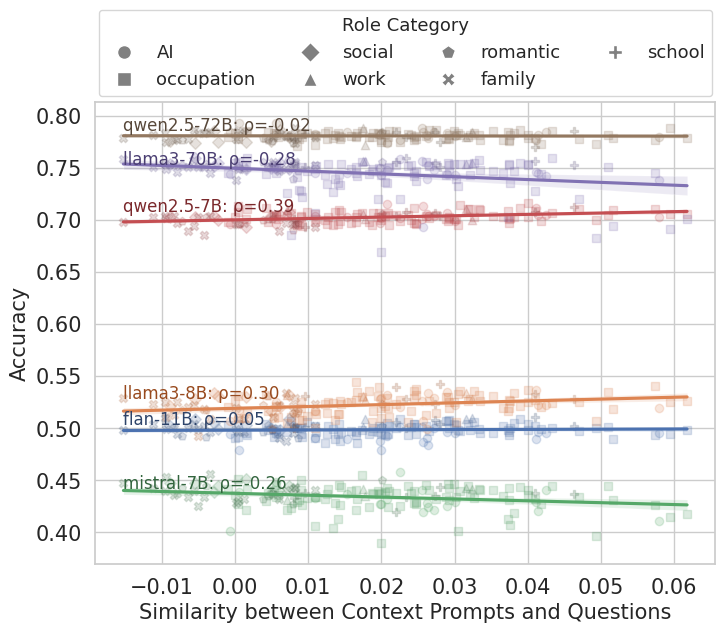

In [351]:
plot_test_acc_sim(model_sim_dic,
                  models=['flan-11B', 'llama3-8B', 'mistral-7B', 'qwen2.5-7B', 'llama3-70B', 'qwen2.5-72B'],
                  file_name = "../shared_data/figures/emnlp-CR/similarity_all.pdf")

## Regression Analysis

In [286]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [287]:
testset_freq_dic['llama3-8B']['freq'].shape

(299376, 8)

In [290]:
testset_dfs = []
model_lst = ['flan', 'llama3-8B', 'mistral', 'qwen2.5-7B']
for m in model_lst:
    common_cols = ['full_question', 'role', 'prompt', 'model']
    freq_df = testset_freq_dic[m]['freq'][common_cols + ['N-gram Frequency (2018-2019)']]
    ppl_df = model_ppl_dic[m]['ppl'][common_cols + ['prompt_ques_ppl']]
    sim_df = model_sim_dic[m]['sim']
    common_cols = ['full_question', 'role', 'prompt', 'model']
    
    merged_df = freq_df.merge(ppl_df, on=common_cols).merge(sim_df, on=common_cols)
    
    testset_dfs.append(merged_df)

testset_all = pd.concat(testset_dfs, ignore_index=True)
testset_all.rename(columns={"N-gram Frequency (2018-2019)": "role_frequency"}, inplace=True)

In [292]:
tdf = testset_all
tdf['log_frequency'] = np.log(tdf.role_frequency/tdf['role_frequency'].max() +1)

tdf['per_frequency'] = tdf['role_frequency'].rank(pct=True) * 100
tdf['per_ppl'] = tdf['prompt_ques_ppl'].rank(pct=True) * 100
tdf['per_sim'] = tdf['prompt_ques_sim'].rank(pct=True) * 100

tdf['log_ppl'] = np.log(tdf.prompt_ques_ppl +1)
# model = smf.mixedlm("accuracy ~ role + merged_cate + role_frequency + prompt_ques_ppl + prompt_ques_sim", 
#                     data=tdf, 
#                     groups=tdf['model'], re_formula="1")
model = smf.mixedlm("accuracy ~ role_frequency + prompt_ques_ppl + prompt_ques_sim", 
                    data=tdf,
                    groups=tdf['model'],
                    re_formula="1")
result = model.fit()

result_df = results_summary_to_dataframe(result)
result_df[result_df['p value']<0.05]

index       p value       coeff         SE  conf_lower  \
1   role_frequency  3.115346e-02  108.638050  50.409585    9.837079   
2  prompt_ques_ppl  2.449544e-02   -0.000398   0.000177   -0.000745   
3  prompt_ques_sim  3.658436e-64    0.418758   0.024761    0.370228   

   conf_higher        term  
1   207.439022   e_frequen  
2    -0.000051  mpt_ques_p  
3     0.467288  mpt_ques_s

In [293]:
# Extract the predictors (independent variables)
predictors = tdf[['role_frequency', 'prompt_ques_ppl', 'prompt_ques_sim']]

# Add a constant term to the predictors (for intercept)
predictors = sm.add_constant(predictors)

# Calculate VIF for each predictor
vif_data = pd.DataFrame()
vif_data['Feature'] = predictors.columns
vif_data['VIF'] = [variance_inflation_factor(predictors.values, i) for i in range(predictors.shape[1])]

vif_threshold = 5
low_vif_columns = vif_data[vif_data['VIF'] < vif_threshold]['Feature'].tolist()
low_vif_columns

['const', 'role_frequency', 'prompt_ques_ppl', 'prompt_ques_sim']

In [294]:
vif_data

Feature       VIF
0            const  4.064114
1   role_frequency  1.002702
2  prompt_ques_ppl  1.032844
3  prompt_ques_sim  1.035482

In [749]:
tdf = testset_all
# model = smf.mixedlm("accuracy ~ role + merged_cate + role_frequency + prompt_ques_ppl + prompt_ques_sim", 
#                     data=tdf, 
#                     groups=tdf['model'], re_formula="1")
model = smf.mixedlm("accuracy ~ role + role_frequency + prompt_ques_ppl + prompt_ques_sim", 
                    data=tdf,
                    groups=tdf['model'],
                    re_formula="1")
result = model.fit(maxiter=100)

/opt/anaconda/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/anaconda/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/anaconda/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
/opt/anaconda/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2054: UserWarning: The random effects covariance matrix is singular.
  warnings.warn(_warn_cov_sing)
/opt/anaconda/lib/python3.10/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/opt/anaconda/lib/python3.10/site-pack

# IV. Role Embedding (see role-embedding notebook for plots)

In [14]:
from sklearn.manifold import TSNE

In [131]:
for model_name, tdf in model_ans_dic.items():
    # Step 1: Calculate the mean accuracy for each pair of role and full_question
    mean_accuracy = tdf.pivot_table(index='full_question', columns='role', values='accuracy', aggfunc='mean')
    
    # Step 2: Create an embedding for each role
    embedding_df = mean_accuracy.T.fillna(0)
    print(f"Embedding done for {model_name}!")

    # Save the embedding to a CSV file
    embedding_df.to_csv(f'../data/{model_name}_role_embedding.csv', index=True)


Embedding done for flan!
Embedding done for llama3-8B!
Embedding done for mistral!
Embedding done for qwen2.5-7B!
Embedding done for qwen2.5-72B!
Embedding done for llama3-70B!


# V. Model Sensitivity

## Sensitivity to Prompts

In [137]:
combined_ans.columns

In [249]:
def plot_prompt_corr(combined_ans, model_name):
    mean_accuracy = combined_ans.groupby(['model', 'role', 'prompt'])['accuracy'].mean().reset_index()
    model_data = mean_accuracy[mean_accuracy['model'] == model_name]
    pivot_table = model_data.pivot(index='role', columns='prompt', values='accuracy')
    
    # Calculate the correlation matrix
    correlation_matrix = pivot_table.corr()

    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title(f'Correlation Heatmap of Role Mean Accuracy across Prompts for {model_name}')
    plt.xticks(rotation=30)
    plt.show()

In [258]:
def calculate_correlation(model_ans_dic, model1, model2, role_column='role', accuracy_column='accuracy'):
    # Compute mean accuracy per role and sort for each model
    model1_role_acc = model_ans_dic[model1].groupby(role_column)[accuracy_column].mean().sort_values(ascending=False).reset_index()
    model2_role_acc = model_ans_dic[model2].groupby(role_column)[accuracy_column].mean().sort_values(ascending=False).reset_index()

    # Merge the dataframes on role
    corr_role_df = model1_role_acc.merge(model2_role_acc, on=role_column, how='left', suffixes=(f'_{model1}', f'_{model2}'))

    # Rank the accuracies for each model
    corr_role_df[f'rank_{model1}'] = corr_role_df[f'{accuracy_column}_{model1}'].rank(ascending=False, method='average')
    corr_role_df[f'rank_{model2}'] = corr_role_df[f'{accuracy_column}_{model2}'].rank(ascending=False, method='average')

    # Calculate Spearman and Pearson correlations
    spearman_corr, spearman_p_value = spearmanr(corr_role_df[f'rank_{model1}'], corr_role_df[f'rank_{model2}'])
    pearson_corr, pearson_p_value = pearsonr(corr_role_df[f'{accuracy_column}_{model1}'], corr_role_df[f'{accuracy_column}_{model2}'])
    
    print(f'Spearman rank correlation: {spearman_corr}, Spearman p-value: {spearman_p_value}')
    print(f'Pearson correlation: {pearson_corr}, Pearson p-value: {pearson_p_value}')

    return corr_role_df

In [260]:
def map_rank_to_accuracy(rank, dataset, model_type):
    """
    Map a rank to its corresponding accuracy for a given model type ('llama' or 'flan').

    :param rank: The rank value to be mapped.
    :param dataset: The DataFrame containing rank and accuracy data.
    :param model_type: A string, either 'llama' or 'flan', indicating the model type.
    :return: The accuracy corresponding to the given rank.
    """
    if model_type == 'llama3-8B':
        rank_column = 'rank_llama'
        accuracy_column = 'accuracy_llama'
    elif model_type == 'flan':
        rank_column = 'rank_flan'
        accuracy_column = 'accuracy_flan'
    elif model_type == 'mistral':
        rank_column = 'rank_mistral'
        accuracy_column = 'accuracy_mistral'
    elif model_type == 'qwen2.5-7B':
        rank_column = 'rank_qwen'
        accuracy_column = 'accuracy_qwen'
    else:
        raise ValueError("Invalid model type.")

    # Find the closest rank in the dataset and return its corresponding accuracy
    nearest_rank_index = np.argmin(np.abs(dataset[rank_column] - rank))
    return dataset.iloc[nearest_rank_index][accuracy_column]

In [261]:
flan_llama_df = calculate_correlation(model_ans_dic, 'flan', 'llama3-8B')

Spearman rank correlation: 0.2605727193665784, Spearman p-value: 0.0008112948000822699
Pearson correlation: 0.23929839044667658, Pearson p-value: 0.0021631214792468484


In [262]:
qwen_mistral_df = calculate_correlation(model_ans_dic, 'mistral', 'qwen2.5-7B')

Spearman rank correlation: 0.3648617861037677, Spearman p-value: 1.8098125303515383e-06
Pearson correlation: 0.444015735543969, Pearson p-value: 3.2527163169122573e-09


In [263]:
role_rank_all = pd.merge(flan_llama_df, qwen_mistral_df, on='role')

In [264]:
role_rank_all.columns

Index(['role', 'accuracy_flan', 'accuracy_llama3-8B', 'rank_flan',
       'rank_llama3-8B', 'accuracy_mistral', 'accuracy_qwen2.5-7B',
       'rank_mistral', 'rank_qwen2.5-7B'],
      dtype='object')

In [270]:
def plot_correlation(role_rank_all, metric="accuracy", figsize=(6,6), file_name=None, title=None):
    rank_columns = [col for col in role_rank_all.columns if metric in col]
    rank_data = role_rank_all[rank_columns]
    rank_correlation_matrix = rank_data.corr()
    np.fill_diagonal(rank_correlation_matrix.values, np.nan)
    
    model_names = [col.split('_')[1] for col in rank_columns]
    
    model_name_mapping = {
        'flan': 'Flan-11B',
        'mistral': 'Mistral-8B',
        'llama3-8B': 'Llama3-8B',
        'qwen2.5-7B': 'Qwen2.5-7B'
        # Add mappings for all your models
    }   
    display_names = [model_name_mapping.get(name, name) for name in model_names]
    center_val = 0
    cmap = sns.color_palette("Blues", as_cmap=True)
    cmap.set_bad(color='white')

    # Create a heatmap to visualize the correlation
    plt.figure(figsize=figsize)
    ax = sns.heatmap(rank_correlation_matrix, annot=True, cmap=cmap, center=0, square=True,
               xticklabels=display_names, yticklabels=display_names)
    
    ax.tick_params(axis='x', labelsize=14, rotation=45)
    ax.tick_params(axis='y', labelsize=14)
    
    if title: 
        plt.title(title)
    if file_name:
        ensure_directory(file_name)
        plt.savefig(file_name, bbox_inches='tight')
    

In [257]:
role_rank_all.head()

role  accuracy_flan  accuracy_llama  rank_flan  rank_llama  \
0     police       0.486307        0.513589        1.0       153.0   
1   stranger       0.485166        0.526452        2.0        67.0   
2     mentor       0.484336        0.535166        3.5         9.0   
3  president       0.484336        0.520228        3.5       123.5   
4    manager       0.483921        0.525415        5.5        78.5   

   accuracy_mistral  accuracy_qwen  rank_mistral  rank_qwen  
0          0.430394       0.529461          82.0       31.5  
1          0.435062       0.531639          37.0       15.0  
2          0.441183       0.531328           4.0       17.0  
3          0.431950       0.524896          67.5       89.0  
4          0.434855       0.528838          40.5       37.5

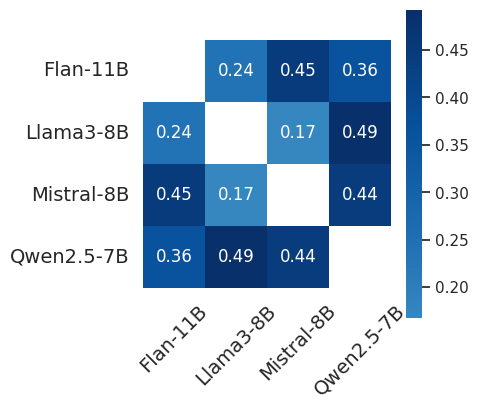

In [271]:
plot_correlation(role_rank_all, "accuracy", figsize=(4,4),
                     file_name = "../shared_data/figures/emnlp-CR/model_heatmap_midsize.pdf")

# Classification 

In [138]:
model_ans_dic['flan'].columns

Index(['model', 'role', 'merged_cate', 'mmlu', 'prompt', 'question_id',
       'dataset', 'accuracy', 'full_question'],
      dtype='object')

- trainset_df_dic stores the answer dataframes of questions in the training set for each model

In [155]:
trainset_df_dic = {}
for model_name, ans_df in model_ans_dic.items():
    trainset_df_dic[model_name] = pd.merge(ans_df[['dataset', 'full_question', 'role', 'merged_cate', 'prompt', 'accuracy', 'domain', 'in_domain']], 
                                          train_ques_df[['dataset', 'full_question']], 
                                          how='right') 
    

## best role per question (best role in testset)

In [156]:
best_per_question = {}
for m, test_df in testset_df_dic.items():
    role_mean = test_df.groupby(['role', 'full_question'])['accuracy'].mean().reset_index()
    best_role_idx = role_mean.groupby(['full_question'])['accuracy'].idxmax()
    best_role = role_mean.loc[best_role_idx].reset_index(drop=True)
    best_role.rename(columns={'accuracy': 'best_acc'}, inplace=True)
    
    best_per_question[m] = best_role

## best in-domain role

In [142]:
trainset_df_dic['flan'].columns

Index(['dataset', 'full_question', 'role', 'merged_cate', 'prompt',
       'accuracy'],
      dtype='object')

In [158]:
best_indomain = {}
for m, train_df in trainset_df_dic.items():
    train_indomain = train_df[train_df['in_domain'] == 1]
    role_mean = train_indomain.groupby(['dataset','role'])['accuracy'].mean().reset_index()
    
    # find the best in-domain role for each dataset
    best_role_idx = role_mean.groupby(['dataset'])['accuracy'].idxmax()
    best_indomain_role = role_mean.loc[best_role_idx].reset_index(drop=True)
    
    # map the best in-domain role to each testset question 
    best_role_ = pd.merge(test_ques_df[['full_question', 'dataset']],
                         best_indomain_role[['dataset', 'role']],
                         how='left')
    
    # map the best indomain role's performance on the testset 
    testset_ques_role_mean = testset_df_dic[m].groupby(['full_question', 'role'])['accuracy'].mean().reset_index()
    
#     test_role_dataset_mean = testset_df_dic[m].groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    best_indomain_on_testset = pd.merge(best_role_,
                                        testset_ques_role_mean,
                                        how='left')
    best_indomain_on_testset.rename(columns={'accuracy': 'best_in-domain_acc'}, inplace=True)

    best_indomain[m] = {'train_indomain_role_mean': role_mean,
                       'best_indomain_role': best_indomain_role,
                       'testset_result': best_indomain_on_testset}

## most similar role

In [161]:
sim_testset.columns

Index(['role', 'prompt', 'full_question', 'context_prompt', 'prompt_ques_sim'], dtype='object')

In [165]:
test_most_sim_role = {}
for m, test_df in testset_df_dic.items():
    print(f'{m} done')
    sim_role = pd.merge(test_df, 
                       sim_testset[['full_question','dataset', 'role', 'prompt', 'prompt_ques_sim']],
                       how='left')
#     sim_role = pd.merge(sim_testset[['context_prompt', 'full_question','role', 'prompt_ques_sim']],
#                         test_df, how='right')

    # pick the most similar role for each question in the testset 
    sim_role_mean = sim_role.groupby(['role', 'full_question'])['prompt_ques_sim'].mean().reset_index()
    sim_role_best_idx = sim_role_mean.groupby(['full_question'])['prompt_ques_sim'].idxmax()
    sim_role_best = sim_role_mean.loc[sim_role_best_idx].reset_index(drop=True)
    
    # map the most similar role to each testset question  
    tdf = pd.merge(test_ques_df[['full_question']],
                   sim_role_best[['full_question', 'role']], 
                   how='left')
#     print(tdf.shape)
    
    testset_ques_role_mean = test_df.groupby(['full_question', 'role'])['accuracy'].mean().reset_index()
#     print(testset_ques_role_mean.shape)
#     test_role_dataset_mean = test_df.groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    most_sim_role = pd.merge(tdf, testset_ques_role_mean, how='left')
    
    most_sim_role.rename(columns={'accuracy': 'most_sim_acc'}, inplace=True)
    
    test_most_sim_role[m] = most_sim_role

flan done
llama3-8B done
mistral done
qwen2.5-7B done
qwen2.5-72B done
llama3-70B done


## dataset prediction

In [170]:
dataset_classification = pd.read_csv("../data/classification/dataset_pred_result.csv")
dataset_classification.rename(columns={'text':'full_question'}, inplace=True)

In [171]:
dataset_classification.shape

(463, 6)

In [624]:
dataset_classification.head()

full_question  true_labels  \
0  Why would you need to carry out a bladder wash...            0   
1  Which of the following is true of calcium meta...            0   
2  Which of the following best describes the effe...            0   
3  Name the bones of the middle finger in the cor...            0   
4  Wound drainage should be assessed for volume a...            0   

   predicted_labels   predicted_dataset        true_dataset  true  
0                 0  clinical_knowledge  clinical_knowledge     1  
1                 5    college_medicine  clinical_knowledge     0  
2                 0  clinical_knowledge  clinical_knowledge     1  
3                 0  clinical_knowledge  clinical_knowledge     1  
4                 0  clinical_knowledge  clinical_knowledge     1

In [172]:
dataset_pred_role = {}
for m, test_df in testset_df_dic.items():
    # map predicted_dataset to its best in-domain role in the training data 
    dataset_pred_ques_role = pd.merge(dataset_classification[['full_question', 'predicted_dataset']],
                                      best_indomain[m]['best_indomain_role'][['dataset', 'role']],
                                      how='left', left_on='predicted_dataset', right_on='dataset')
    
    testset_ques_role_mean = test_df.groupby(['full_question', 'role'])['accuracy'].mean().reset_index()
    
    # map the best in-domain role to its actual accuracy in the test set 
    dataset_pred_ques_result = pd.merge(dataset_pred_ques_role,
                                        testset_ques_role_mean, 
                                        how='left')
    
    dataset_pred_ques_result.rename(columns={'accuracy': 'pred_best_indomain_acc'}, inplace=True)
    
    dataset_pred_role[m] = dataset_pred_ques_result

## role prediction

In [195]:
classification_question_split.columns

Index(['question', 'subject', 'true_option', 'groundtruth', 'dataset',
       'length', 'question_id', 'option1', 'option2', 'option3', 'option4',
       'full_question', 'split'],
      dtype='object')

### Step1 - Prepare training data

In [174]:
all_roles = sorted({role for df in model_ans_dic.values() for role in df['role']})

# Create a dictionary to map roles to their indices in the array
role_index_map = {role: idx for idx, role in enumerate(all_roles)}

index_role_map = {idx: role for role, idx in role_index_map.items()}

In [175]:
aggregated_ans_dic = {}
for model, ans_df in model_ans_dic.items():
    aggregated_ans = ans_df.groupby(['full_question', 'role']).agg({'accuracy': 'mean'}).reset_index()
    aggregated_ans_dic[model] = aggregated_ans

In [176]:
aggregated_ans_dic['flan'].columns

Index(['full_question', 'role', 'accuracy'], dtype='object')

In [177]:
base_df = classification_question_split[['full_question']].copy()
base_df['roles'] = base_df['full_question'].apply(lambda x: [0] * len(all_roles))

In [178]:
role_classifier_dfs = {}
for model, aggregated_ans_df in aggregated_ans_dic.items():
    print(f'Processing {model}')
    output_df = base_df.copy()
    
    for _, row in aggregated_ans_df.iterrows():
        question_idx = output_df[output_df['full_question'] == row['full_question']].index[0]
        role_idx = role_index_map[row['role']]
        # Assign binary indicator based on average accuracy
        output_df.at[question_idx, 'roles'][role_idx] = int(row['accuracy'] >= 0.5)
  
    role_classifier_dfs[model] = output_df

Processing flan
Processing llama3-8B
Processing mistral
Processing qwen2.5-7B
Processing qwen2.5-72B
Processing llama3-70B


In [179]:
class_model_lst = ['qwen2.5-72B', 'llama3-70B']
for m, df in role_classifier_dfs.items():
    if m in class_model_lst:
        train_df = pd.merge(df, classification_question_split[['full_question', 'split']], how='left')
        train_df = train_df.rename(columns={'roles':'accuracy'})
        train_df.to_csv(f"../data/classification/{m}_role_classification.csv", index=False)

### Step2 - Process prediction result

In [199]:
def string_to_list_of_ints(s):
    cleaned = s.replace("[", "").replace("]", "").replace("\n", "")
    return [float(x) for x in cleaned.split()]

In [201]:
role_pred_raw_result = {'flan': '../roberta-base-role-classifier-full-question-flan-updated/flan_role_pred.csv',
                       'llama3-70B': '../roberta-base-role-classifier-full-question-llama3-70B-updated/llama3-70B_role_pred.csv',
                       'mistral': '../roberta-base-role-classifier-full-question-mistral-updated/mistral_role_pred.csv',
                       'qwen2.5-72B': '../roberta-base-role-classifier-full-question-qwen2.5-72B-updated/qwen2.5-72B_role_pred.csv'}

In [197]:
def get_best_predicted_role(predicted_labels):
    max_index = predicted_labels.index(max(predicted_labels))
    return index_role_map[max_index]

In [202]:
role_pred_result = {}
for m, raw_path in role_pred_raw_result.items():
    raw_df = pd.read_csv(raw_path)
    raw_df['predicted_labels'] = raw_df['predicted_labels'].apply(string_to_list_of_ints)
    raw_df['role'] = raw_df['predicted_labels'].apply(get_best_predicted_role)
    raw_df.rename(columns={'text':'full_question'})
    testset_ques_role_mean = testset_df_dic[m].groupby(['full_question', 'role'])['accuracy'].mean().reset_index()
    
    role_pred_acc = pd.merge(raw_df,
                             testset_ques_role_mean,
                             how='left')
    role_pred_acc.rename(columns={'accuracy': 'pred_role_acc'}, inplace=True)
    
    role_pred_result[m] = {'raw_result': raw_df,
                          'role_pred_acc': role_pred_acc}

In [203]:
role_pred_result['flan']['role_pred_acc'].head()

text  \
0  Why would you need to carry out a bladder wash...   
1  Why would you need to carry out a bladder wash...   
2  Why would you need to carry out a bladder wash...   
3  Why would you need to carry out a bladder wash...   
4  Why would you need to carry out a bladder wash...   

                                         true_labels  \
0  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
1  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
2  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
3  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   
4  [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1...   

                                    predicted_labels  \
0  [0.15872936, 0.19249786, 0.14719343, 0.1523311...   
1  [0.15872936, 0.19249786, 0.14719343, 0.1523311...   
2  [0.15872936, 0.19249786, 0.14719343, 0.1523311...   
3  [0.15872936, 0.19249786, 0.14719343, 0.1523311...   
4  [0.15872936, 0.19249786, 0.14719343, 0.1523311...   

                         role  \
0  Psychological Profiling AI   
1  Psychological Profiling AI   
2  Psychological Profiling AI   
3  Psychological Profiling AI   
4  Psychological Profiling AI   

                                       full_question  pred_role_acc  
0  "The basic premise of the “Zeigarnik effect"" ...            1.0  
1  A 14-year-old girl has had nausea, intermitten...            0.0  
2  A 15-year-old male is brought to the office wi...            1.0  
3  A 2008 survey of 500 households concluded that...            1.0  
4  A 25 g sample of a liquid was heated to 100 °C...            0.0

## best on training set

In [223]:
trainset_df_dic['flan'].groupby('role')['accuracy'].mean().sort_values(ascending=False).reset_index().loc[0]

role          police
accuracy    0.483724
Name: 0, dtype: object

In [224]:
trainset_df_dic['llama'].groupby('role')['accuracy'].mean().sort_values(ascending=False).reset_index().loc[0]

role        statistician
accuracy        0.549413
Name: 0, dtype: object

In [210]:
best_role_in_train = {}

for m, train_df in trainset_df_dic.items():
    role = train_df.groupby('role')['accuracy'].mean().sort_values(ascending=False).reset_index().loc[0]['role']
    testset_ques_role_mean = testset_df_dic[m].groupby(['full_question', 'role'])['accuracy'].mean().reset_index()
    
#     test_role_dataset_mean = testset_df_dic[m].groupby(['dataset', 'role'])['accuracy'].mean().reset_index()
    best_role_acc = testset_ques_role_mean[testset_ques_role_mean['role'] == role]
    
    train_best_role = pd.merge(test_ques_df[['full_question']], 
                               best_role_acc, how='left')
    train_best_role.rename(columns={'accuracy': 'train_best_role_acc'}, inplace=True)
    best_role_in_train[m] = train_best_role

In [226]:
best_role_in_train['flan'].head()

full_question    role  \
0  Why would you need to carry out a bladder wash...  police   
1  Which of the following is true of calcium meta...  police   
2  Which of the following best describes the effe...  police   
3  Name the bones of the middle finger in the cor...  police   
4  Wound drainage should be assessed for volume a...  police   

   train_best_role_acc  
0                  0.0  
1                  1.0  
2                  1.0  
3                  0.0  
4                  1.0

## random baseline

In [204]:
test_ques_df.columns

Index(['question', 'subject', 'true_option', 'groundtruth', 'dataset',
       'length', 'question_id', 'option1', 'option2', 'option3', 'option4',
       'full_question', 'split'],
      dtype='object')

In [205]:
def random_baseline_acc(test_ques_df, test_role_ques_mean, n_iterations=5):
    cumulative_accuracy_df = pd.DataFrame()
    roles = list(role_index_map.keys())
    np.random.seed(43)

    for _ in range(n_iterations):
        # Random role assignment
        random_df = test_ques_df.copy()
        random_df['role'] = np.random.choice(roles, size=len(random_df))

        # Merge with the mean accuracy DataFrame
        ques_random_df = pd.merge(
            random_df[['full_question', 'role']],
            test_role_ques_mean[['full_question', 'role', 'accuracy']],
            how='left'
        )

        # If this is the first iteration, initialize cumulative_accuracy_df
        if cumulative_accuracy_df.empty:
            cumulative_accuracy_df = ques_random_df[['full_question', 'accuracy']].copy()
            cumulative_accuracy_df.rename(columns={'accuracy': 'cumulative_accuracy'}, inplace=True)
        else:
            # Add the accuracy of this iteration to the cumulative accuracy
            cumulative_accuracy_df['cumulative_accuracy'] += ques_random_df['accuracy']

    cumulative_accuracy_df['average_accuracy'] = cumulative_accuracy_df['cumulative_accuracy'] / n_iterations
    cumulative_accuracy_df.rename(columns={'average_accuracy': 'random_baseline'}, inplace=True)
    return cumulative_accuracy_df

In [206]:
random_dic = {}
for m, test in testset_df_dic.items():
    random_dic[m] = random_baseline_acc(test_ques_df, 
                                        test.groupby(['role', 'full_question'])['accuracy'].mean().reset_index())

## testset control

In [207]:
test_ctrl_dic = {}
for m, ctrl in model_ctrl_dic.items():
    test_ctrl_dic[m] = pd.merge(test_ques_df, ctrl, how='left')
    test_ctrl_dic[m].rename(columns={'accuracy':'control'}, inplace=True)

In [208]:
test_ctrl_dic['flan'].shape

(462, 18)

## results for automatic role picking

In [212]:
from functools import reduce

In [213]:
models = ['flan', 'llama3-70B', 'mistral', 'qwen2.5-72B']

role_pick_result_all = {}
for m in models:
    ctrl = test_ctrl_dic[m][['full_question', 'control']]
    best_role = best_per_question[m][['full_question', 'best_acc']]
    best_indomain_role = best_indomain[m]['testset_result'][['full_question', 'best_in-domain_acc']]
    most_sim = test_most_sim_role[m][['full_question', 'most_sim_acc']]
    dataset_pred = dataset_pred_role[m][['full_question', 'pred_best_indomain_acc']]
    role_pred = role_pred_result[m]['role_pred_acc'][['full_question', 'pred_role_acc']]
    best_train = best_role_in_train[m][['full_question', 'train_best_role_acc']]
    random_baseline = random_dic[m][['full_question', 'random_baseline']]
    
    dfs = [ctrl, best_role, best_indomain_role, most_sim, dataset_pred, role_pred, best_train, random_baseline]
    merged_df = reduce(lambda left, right: pd.merge(left, right, on=['full_question']), dfs)
    role_pick_result_all[m] = merged_df

In [215]:
role_pick_result_all['llama3-70B'].columns

Index(['full_question', 'control', 'best_acc', 'best_in-domain_acc',
       'most_sim_acc', 'pred_best_indomain_acc', 'pred_role_acc',
       'train_best_role_acc', 'random_baseline'],
      dtype='object')

In [216]:
from statsmodels.stats.contingency_tables import mcnemar 

In [248]:
m = 'qwen'
best_role_df = best_per_question[m]
ctrl_df = test_ctrl_dic[m]

best_role_df['true'] = (best_role_df['best_acc'] > 0.5).astype(int)

best_lst = best_role_df['true'].tolist()
ctrl_lst = ctrl_df['control'].tolist()
table = [[0, 0], [0, 0]]

for a, b in zip(best_lst, ctrl_lst):
    table[a][b] += 1

result = mcnemar(table, exact=True)
result.pvalue

1.2593457491380364e-07

/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py:471: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  
/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py:477: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  


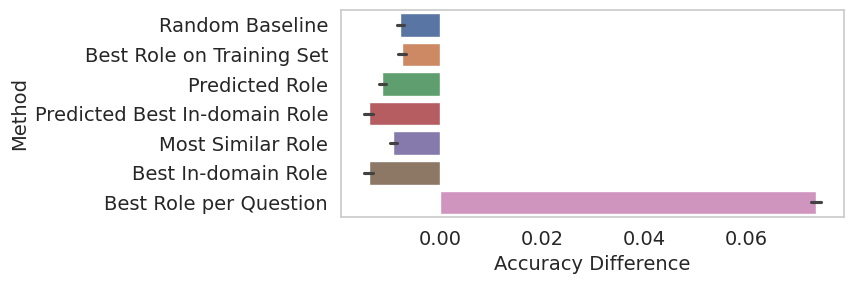

In [233]:
tdf = role_pick_result_all['qwen2.5-72B']
plot_role_pick(tdf,
               palette_type=sns.color_palette(),
               figsize=(8.7,3),
               file_name = "../shared_data/figures/emnlp-CR/role_pick_qwen2.5-72B.pdf")

/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py:471: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  


/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py:477: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  


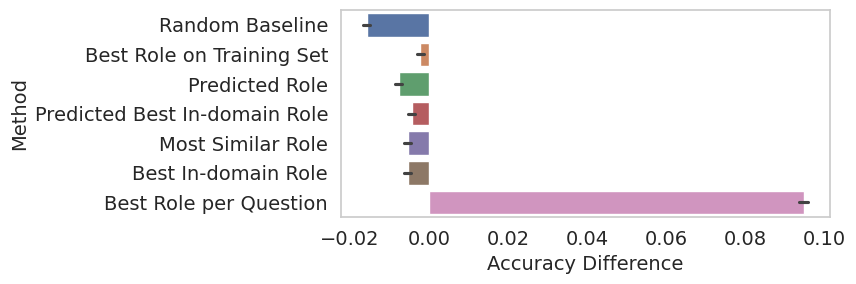

In [231]:
tdf = role_pick_result_all['llama3-70B']
plot_role_pick(tdf,
               palette_type=sns.color_palette(),
               figsize=(8.7,3),
               file_name = "../shared_data/figures/emnlp-CR/role_pick_llama3-70B.pdf")

/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py:471: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  
/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py:477: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  


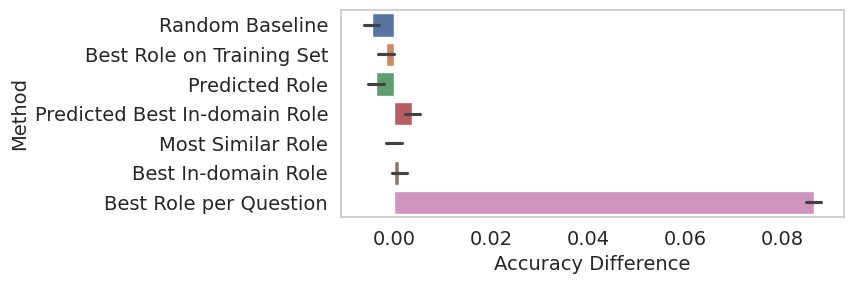

In [235]:
tdf = role_pick_result_all['flan']
plot_role_pick(tdf,
               palette_type=sns.color_palette(),
               figsize=(8.7,3),
               file_name = "../shared_data/figures/emnlp-CR/role_pick_flan.pdf")

/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py:471: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  
/shared/3/projects/mingqian/social-prompt/notebooks/plot_utilities.py:477: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  


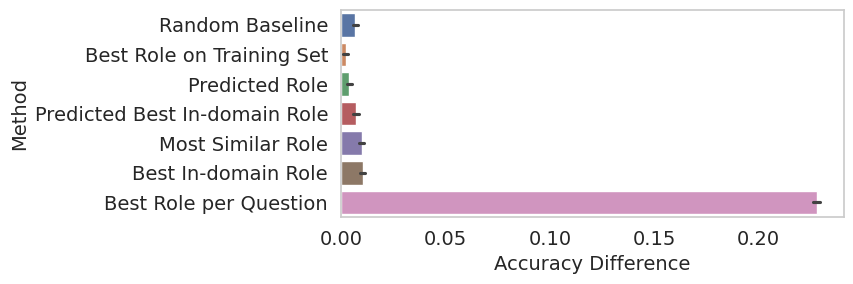

In [236]:
tdf = role_pick_result_all['mistral']
plot_role_pick(tdf,
               palette_type=sns.color_palette(),
               figsize=(8.7,3),
               file_name = "../shared_data/figures/emnlp-CR/role_pick_mistral.pdf")